## Drone delivery

In [261]:
# 导入必要的库
import gurobipy as gp
import math
from gurobipy import Model, GRB, quicksum, tupledict
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [262]:
# Define the file path
file_path = 'dataset/pdp_100/lr210.txt'

# Read the file lines
with open(file_path, 'r') as file:
    lines = file.readlines()

# First line corresponds to the first DataFrame with number of vehicles, vehicle capacity, and speed
header_data = lines[0].strip().split('\t')
header_df = pd.DataFrame([header_data], columns=["NUMBER OF VEHICLES", "VEHICLE CAPACITY", "SPEED (not used)"])

# The remaining lines correspond to the second DataFrame with task details
task_data = [line.strip().split('\t') for line in lines[1:]]
columns = ["TASK NO.", "X", "Y", "DEMAND", "EARLIEST PICKUP/DELIVERY TIME", 
           "LATEST PICKUP/DELIVERY TIME", "SERVICE TIME", "PICKUP(index to sibling)", "DELIVERY(index to sibling)"]
task_df = pd.DataFrame(task_data, columns=columns)

# Display the dataframes
print("Header DataFrame:")
print(header_df)

print("\nTask Details DataFrame:")
print(task_df)

Header DataFrame:
  NUMBER OF VEHICLES VEHICLE CAPACITY SPEED (not used)
0                 25             1000                1

Task Details DataFrame:
    TASK NO.   X   Y DEMAND EARLIEST PICKUP/DELIVERY TIME  \
0          0  35  35      0                             0   
1          1  41  49     10                           190   
2          2  35  17    -41                            18   
3          3  55  45     -5                           289   
4          4  55  20     19                           679   
..       ...  ..  ..    ...                           ...   
98        98  19  21     10                            21   
99        99  20  26      9                           328   
100      100  18  18    -31                           821   
101      101  53  12     -6                           525   
102      102  15  77     -9                           154   

    LATEST PICKUP/DELIVERY TIME SERVICE TIME PICKUP(index to sibling)  \
0                          1000          

In [263]:
task_df

,TASK NO.,X,Y,DEMAND,EARLIEST PICKUP/DELIVERY TIME,LATEST PICKUP/DELIVERY TIME,SERVICE TIME,PICKUP(index to sibling),DELIVERY(index to sibling)
0,0,35,35,0,0,1000,0,0,0
1,1,41,49,10,190,974,10,0,70
2,2,35,17,-41,18,792,10,85,0
3,3,55,45,-5,289,822,10,42,0
4,4,55,20,19,679,800,10,0,55
...,...,...,...,...,...,...,...,...,...
98,98,19,21,10,21,748,10,0,67
99,99,20,26,9,328,437,10,0,22
100,100,18,18,-31,821,965,10,39,0
101,101,53,12,-6,525,752,10,56,0


In [264]:
# 将 DEMAND 列转换为整数类型
task_df = task_df.apply(pd.to_numeric, errors='coerce')


# 定义一个函数来判断任务类型
def determine_task_type(row):

    if row["DEMAND"] < 0:
        return "pickup"
    elif row["DEMAND"] > 0:
        return "delivery"
    else:
        return "depot"

# 应用函数并新增一列
task_df['TASK TYPE'] = task_df.apply(determine_task_type, axis=1)


In [265]:
task_df

,TASK NO.,X,Y,DEMAND,EARLIEST PICKUP/DELIVERY TIME,LATEST PICKUP/DELIVERY TIME,SERVICE TIME,PICKUP(index to sibling),DELIVERY(index to sibling),TASK TYPE
0,0,35,35,0,0,1000,0,0,0,depot
1,1,41,49,10,190,974,10,0,70,delivery
2,2,35,17,-41,18,792,10,85,0,pickup
3,3,55,45,-5,289,822,10,42,0,pickup
4,4,55,20,19,679,800,10,0,55,delivery
...,...,...,...,...,...,...,...,...,...,...
98,98,19,21,10,21,748,10,0,67,delivery
99,99,20,26,9,328,437,10,0,22,delivery
100,100,18,18,-31,821,965,10,39,0,pickup
101,101,53,12,-6,525,752,10,56,0,pickup


	1.	任务 0:
	•	TASK NO. 0 是仓库（Depot），它的坐标是 (40, 50)，需求量（DEMAND）为 0。
	•	任务 0 的 PICKUP(index to sibling) 和 DELIVERY(index to sibling) 都是 0，表示这是仓库，不涉及取货或送货操作。

	2.	任务 1:
	•	TASK NO. 1 是一个送货任务，坐标是 (45, 68)，需求量（DEMAND）是 -10，表示需要把 10 单位的货物送到这个地点。
	•	任务 1 的 PICKUP(index to sibling) 为 2，表示任务 1 的对应取货任务是 TASK NO. 2。
	 red line: from green point to orange point
	
	3.	任务 2:
	•	TASK NO. 2 是一个取货任务，坐标和任务 1 一样都是 (45, 68)，需求量（DEMAND）是 10，表示需要从这个地点取 10 单位的货物。
	•	任务 2 的 DELIVERY(index to sibling) 为 1，表示任务 2 的对应送货任务是 TASK NO. 1。
	 blue line: from green point to orange point


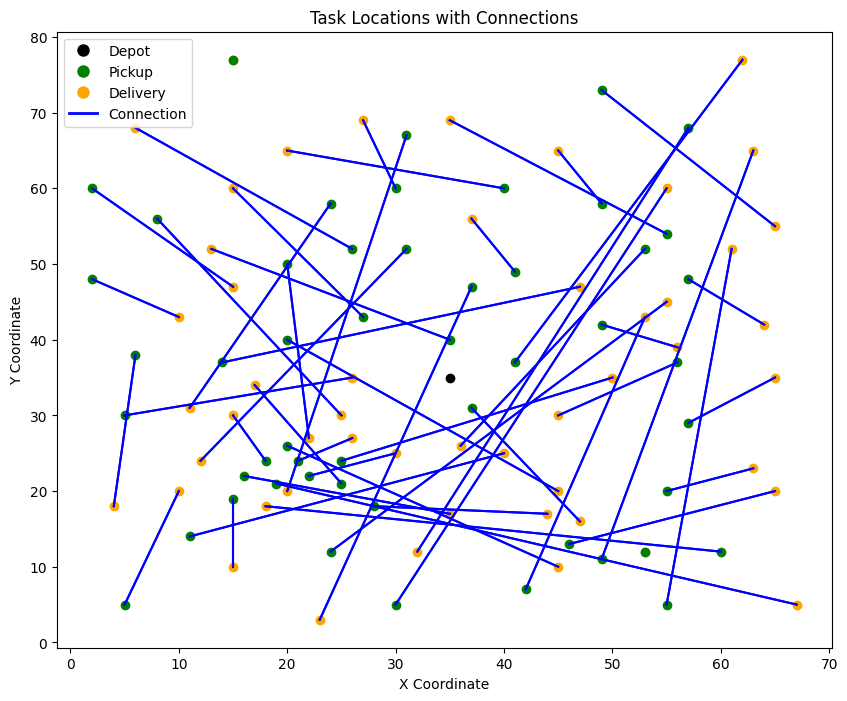

In [266]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 假设 task_df 已经被创建，并且所有列都已经转换为数值类型
# 将 'PICKUP(index to sibling)' 和 'DELIVERY(index to sibling)' 合并为 'CONNECTION' 列
task_df['CONNECTION'] = task_df[['PICKUP(index to sibling)', 'DELIVERY(index to sibling)']].max(axis=1)
task_df['CONNECTION'] = pd.to_numeric(task_df['CONNECTION'], errors='coerce').fillna(0).astype(int)

# 创建 'photos' 文件夹，如果它不存在
os.makedirs('photos', exist_ok=True)

# 先创建一个空白图
plt.figure(figsize=(10, 8))

# 遍历每一行
for _, row in task_df.iterrows():
    task_type = row['TASK TYPE']
    x, y = row['X'], row['Y']
    
    if task_type == 'depot':
        # 绘制仓库（黑色）
        plt.scatter(x, y, color='black')
    
    elif task_type in ['pickup', 'delivery']:
        # 找到对应的连接任务
        sibling_index = row['CONNECTION']
        if sibling_index > 0:
            sibling_row = task_df.iloc[sibling_index]
            sibling_x, sibling_y = sibling_row['X'], sibling_row['Y']
            
            # 绘制连接任务（绿色）
            plt.scatter(sibling_x, sibling_y, color='green' if task_type == 'pickup' else 'orange')
            
            # 绘制连接线（蓝色）
            plt.plot([x, sibling_x], [y, sibling_y], color='blue')
        else:
            # 单独绘制 pickup 或 delivery 任务
            plt.scatter(x, y, color='green' if task_type == 'pickup' else 'orange')

# 添加图例
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Depot'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Pickup'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Delivery'),
    plt.Line2D([0], [0], color='blue', lw=2, label='Connection')
])

# 设置标题和标签
plt.title('Task Locations with Connections')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')



# 显示图表
plt.grid(False)
plt.show()

In [267]:

# 创建一个空的列表来存储配对数据
pairs = []

# 遍历每一行，找到pickup和对应的delivery
for _, row in task_df.iterrows():
    if row['TASK TYPE'] == 'pickup':
        # 找到对应的delivery任务
        sibling_index = row['CONNECTION']
        sibling_row = task_df.iloc[sibling_index]
        
        # 将pickup和delivery任务配对，并存入列表
        pair = {
            'pickup_task': row['TASK NO.'],
            'pickup_x': row['X'],
            'pickup_y': row['Y'],
            'pickup_earliest_time': row['EARLIEST PICKUP/DELIVERY TIME'],
            'pickup_latest_time': row['LATEST PICKUP/DELIVERY TIME'],
            'delivery_task': sibling_row['TASK NO.'],
            'delivery_x': sibling_row['X'],
            'delivery_y': sibling_row['Y'],
            'delivery_earliest_time': sibling_row['EARLIEST PICKUP/DELIVERY TIME'],
            'delivery_latest_time': sibling_row['LATEST PICKUP/DELIVERY TIME']
        }
        pairs.append(pair)

# 将列表转换为DataFrame
pairs_df = pd.DataFrame(pairs)

# 计算每对任务之间的欧几里得距离
pairs_df['distance'] = pairs_df.apply(lambda row: np.sqrt((row['pickup_x'] - row['delivery_x'])**2 +
                                                          (row['pickup_y'] - row['delivery_y'])**2), axis=1)

# 输出配对数据
pairs_df

,pickup_task,pickup_x,pickup_y,pickup_earliest_time,pickup_latest_time,delivery_task,delivery_x,delivery_y,delivery_earliest_time,delivery_latest_time,distance
0,2,35,17,18,792,85,16,22,110,727,19.646883
1,3,55,45,289,822,42,24,12,25,292,45.276926
2,5,15,30,20,906,93,18,24,691,969,6.708204
3,6,25,30,355,574,47,8,56,34,602,31.064449
4,8,10,43,393,492,46,2,48,338,805,9.433981
5,9,55,60,394,503,15,30,5,176,299,60.415230
6,11,20,65,206,325,30,40,60,199,414,20.615528
7,12,50,35,15,725,95,25,24,14,793,27.313001
8,13,30,25,694,823,92,22,22,18,159,8.544004
9,14,15,10,32,694,91,15,19,222,964,9.000000


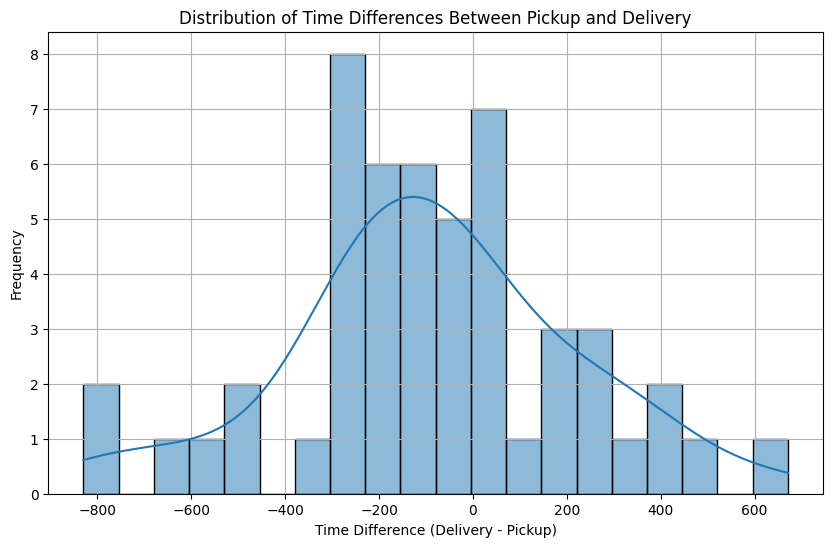

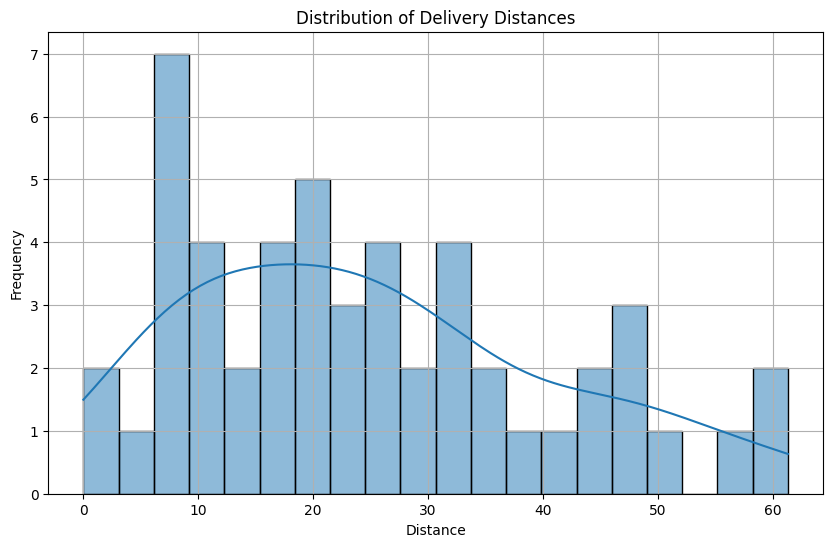

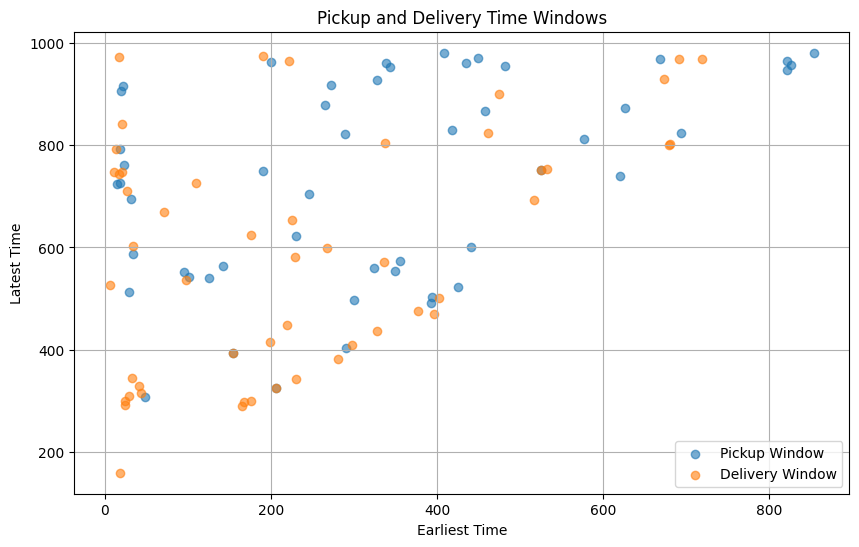

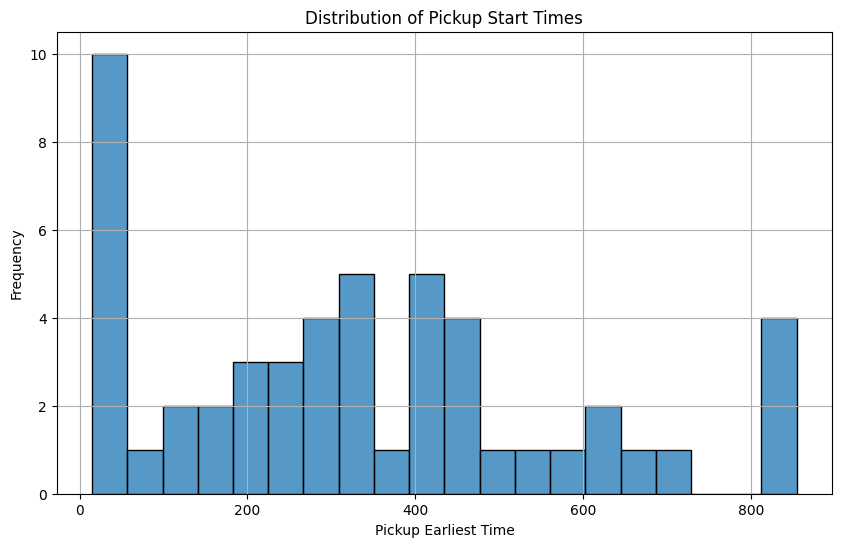

In [268]:
############整一个list或者dictionary来record，把pickup time排序，然后每个index对应一个earliest pick point，然后一个一个go through
#######可以假设有无数个delivery drones，当我有一个pick up task，然后就有一个drone在等待，如果没有等待就加一个新的drone
############下一个task是考虑delivery，就直接假设每次我开始pick up的时候就有一个drone在等待，并进行之后的deliver
import matplotlib.pyplot as plt

import seaborn as sns

# 1. 计算取货和送货的时间差
pairs_df['time_difference'] = pairs_df['delivery_earliest_time'] - pairs_df['pickup_earliest_time']

# 绘制取货和送货的时间间隔分布
plt.figure(figsize=(10, 6))
sns.histplot(pairs_df['time_difference'], bins=20, kde=True)
plt.title('Distribution of Time Differences Between Pickup and Delivery')
plt.xlabel('Time Difference (Delivery - Pickup)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. 绘制任务距离的分布情况
plt.figure(figsize=(10, 6))
sns.histplot(pairs_df['distance'], bins=20, kde=True)
plt.title('Distribution of Delivery Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. 取货/送货的时间窗口散点图
plt.figure(figsize=(10, 6))
plt.scatter(pairs_df['pickup_earliest_time'], pairs_df['pickup_latest_time'], label='Pickup Window', alpha=0.6)
plt.scatter(pairs_df['delivery_earliest_time'], pairs_df['delivery_latest_time'], label='Delivery Window', alpha=0.6)
plt.title('Pickup and Delivery Time Windows')
plt.xlabel('Earliest Time')
plt.ylabel('Latest Time')
plt.legend()
plt.grid(True)
plt.show()

# 4. 任务开始时间的条形图
plt.figure(figsize=(10, 6))
sns.histplot(pairs_df['pickup_earliest_time'], bins=20, kde=False)
plt.title('Distribution of Pickup Start Times')
plt.xlabel('Pickup Earliest Time')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [269]:
# import matplotlib.pyplot as plt
# import pandas as pd
# from matplotlib.animation import FuncAnimation

# # 假设 pairs_df 已经加载并且包含以下列：pickup_x, pickup_y, delivery_x, delivery_y, pickup_earliest_time, delivery_latest_time
# # pairs_df = pd.read_csv('your_data.csv')

# # 计算平均时间（取 earliest 和 latest 的平均值）
# pairs_df['pickup_avg_time'] = (pairs_df['pickup_earliest_time'] + pairs_df['pickup_latest_time']) / 2
# pairs_df['delivery_avg_time'] = (pairs_df['delivery_earliest_time'] + pairs_df['delivery_latest_time']) / 2

# # 动图设置
# fig, ax = plt.subplots(figsize=(10, 6))

# # 初始设置
# def init():
#     ax.set_xlim(pairs_df['pickup_x'].min() - 5, pairs_df['delivery_x'].max() + 5)
#     ax.set_ylim(pairs_df['pickup_y'].min() - 5, pairs_df['delivery_y'].max() + 5)
#     ax.set_title('Pickup and Delivery Animation')
#     ax.set_xlabel('X Coordinate')
#     ax.set_ylabel('Y Coordinate')

# # 更新函数
# def update(frame):
#     ax.clear()
#     init()
    
#     # 获取当前时间下的pickup和delivery点
#     current_pickups = pairs_df[pairs_df['pickup_avg_time'] <= frame]
#     current_deliveries = pairs_df[pairs_df['delivery_avg_time'] <= frame]
    
#     # 绘制 pickup 和 delivery 的点及连接线
#     for index, row in current_pickups.iterrows():
#         ax.scatter(row['pickup_x'], row['pickup_y'], color='green', label='Pickup' if index == 0 else "", s=50)
        
#     for index, row in current_deliveries.iterrows():
#         ax.scatter(row['delivery_x'], row['delivery_y'], color='red', label='Delivery' if index == 0 else "", s=50)
#         # 画线从pickup到delivery
#         ax.plot([row['pickup_x'], row['delivery_x']], [row['pickup_y'], row['delivery_y']], color='blue', linestyle='--', alpha=0.7)
    
#     # 设置图例
#     ax.legend()

# # 创建动画，100帧，每帧间隔200ms
# ani = FuncAnimation(fig, update, frames=range(int(pairs_df['pickup_avg_time'].min()), int(pairs_df['delivery_avg_time'].max())), init_func=init, repeat=False)

# # 保存为gif (如果需要)
# ani.save('pickup_delivery_animation.gif', writer='imagemagick', fps=10)

# # 显示动画
# plt.show()

In [270]:
import pandas as pd

# Define the bus lines with stations every 10 units
bus_stations = []

# First bus line from (10, 0) to (10, 60) to (70, 60)
for y in range(0, 70, 10):  # Cover (10,0) to (10,60) inclusive
    bus_stations.append({'line': 'Line 1', 'x': float(10), 'y': float(y)})
for x in range(20, 80, 10):  # Cover (10,60) to (70,60) inclusive
    bus_stations.append({'line': 'Line 1', 'x': float(x), 'y': float(60)})

# Second bus line from (0, 20) to (50, 20) to (50, 80)
for x in range(0, 60, 10):  # Cover (0,20) to (50,20) inclusive
    bus_stations.append({'line': 'Line 2', 'x': float(x), 'y': float(20)})
for y in range(30, 90, 10):  # Cover (50,20) to (50,80) inclusive
    bus_stations.append({'line': 'Line 2', 'x': float(50), 'y': float(y)})

# Convert to DataFrame
bus_stations_df = pd.DataFrame(bus_stations)

# Ensure columns 'x' and 'y' are of float type
bus_stations_df['x'] = bus_stations_df['x'].astype(float)
bus_stations_df['y'] = bus_stations_df['y'].astype(float)

# Display the DataFrame
bus_stations_df

,line,x,y
0,Line 1,10.0,0.0
1,Line 1,10.0,10.0
2,Line 1,10.0,20.0
3,Line 1,10.0,30.0
4,Line 1,10.0,40.0
5,Line 1,10.0,50.0
6,Line 1,10.0,60.0
7,Line 1,20.0,60.0
8,Line 1,30.0,60.0
9,Line 1,40.0,60.0


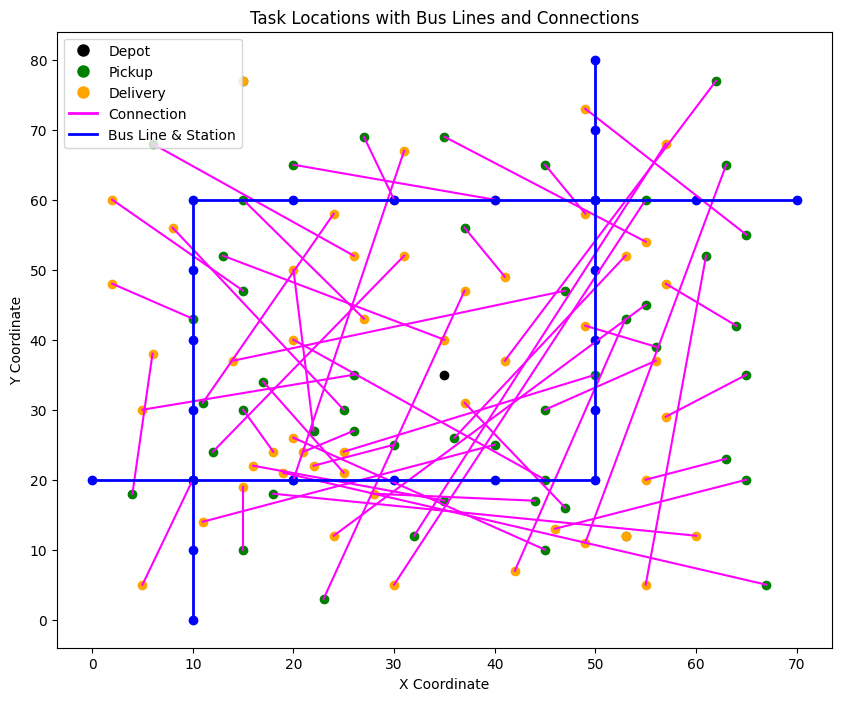

In [271]:
import matplotlib.pyplot as plt

# Existing plot setup for tasks (pickup, delivery, depot)
plt.figure(figsize=(10, 8))

# 遍历每一行，绘制pickup和delivery点及其连接
for _, row in task_df.iterrows():
    task_type = row['TASK TYPE']
    x, y = row['X'], row['Y']
    
    if task_type == 'depot':
        plt.scatter(x, y, color='black')
    elif task_type == 'pickup':
        sibling_index = row['CONNECTION']
        sibling_row = task_df.iloc[sibling_index]
        sibling_x, sibling_y = sibling_row['X'], sibling_row['Y']
        plt.scatter(x, y, color='green')
        plt.scatter(sibling_x, sibling_y, color='orange')
        plt.plot([x, sibling_x], [y, sibling_y], color='magenta')
    elif task_type == 'delivery':
        continue  # Already plotted in 'pickup' part

# Plotting the bus stations and lines
for line in bus_stations_df['line'].unique():
    line_stations = bus_stations_df[bus_stations_df['line'] == line]
    
    # Plot bus stations in red
    plt.scatter(line_stations['x'], line_stations['y'], color='blue', label=f'{line} Bus Station')

    # Draw lines connecting bus stations
    plt.plot(line_stations['x'], line_stations['y'], color='blue', linestyle='-', linewidth=2)

# Adding legends
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Depot'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Pickup'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Delivery'),
    plt.Line2D([0], [0], color='magenta', lw=2, label='Connection'),
    plt.Line2D([0], [0], color='blue', lw=2, label='Bus Line & Station')
])

# Set plot title and labels
plt.title('Task Locations with Bus Lines and Connections')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# # 保存图表到 'photos/lr210.png'
plt.savefig('photos/lr210.png')

# Display the plot
plt.grid(False)
plt.show()

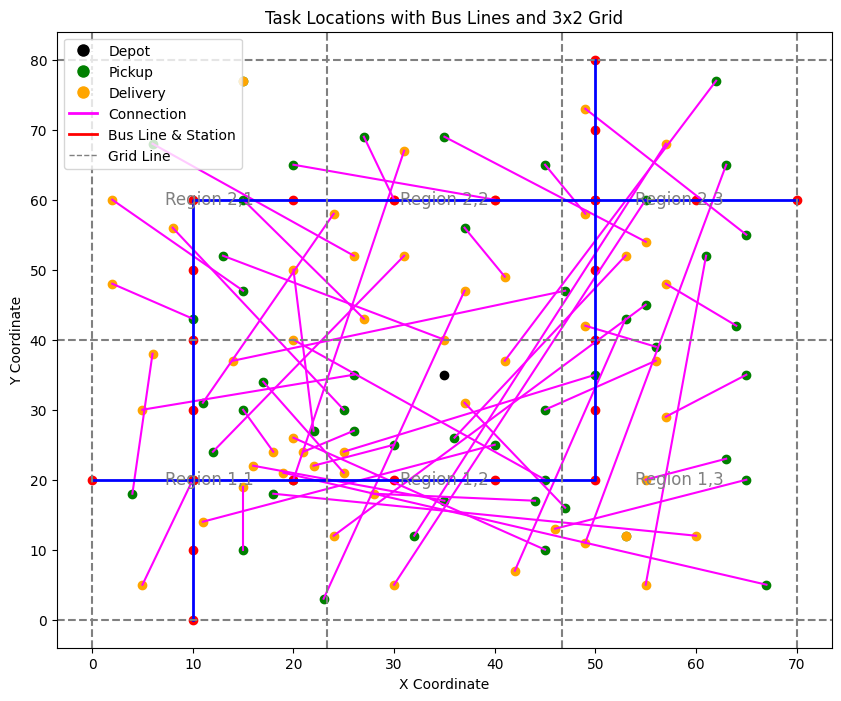

In [272]:
import numpy as np

# Determine the boundaries of the plot (adjust if necessary based on your plot limits)
x_min, x_max = 0, 70  # Adjust these limits according to the actual size of your plot
y_min, y_max = 0, 80  # Adjust these limits according to the actual size of your plot

# Divide the region into 3 columns and 2 rows
x_intervals = np.linspace(x_min, x_max, 4)  # 3 columns
y_intervals = np.linspace(y_min, y_max, 3)  # 2 rows

# Plot the existing data
plt.figure(figsize=(10, 8))

# Plotting pickup, delivery, and depot points with connections (as in your previous steps)
for _, row in task_df.iterrows():
    task_type = row['TASK TYPE']
    x, y = row['X'], row['Y']
    
    if task_type == 'depot':
        plt.scatter(x, y, color='black')
    elif task_type == 'pickup':
        sibling_index = row['CONNECTION']
        sibling_row = task_df.iloc[sibling_index]
        sibling_x, sibling_y = sibling_row['X'], sibling_row['Y']
        plt.scatter(x, y, color='green')
        plt.scatter(sibling_x, sibling_y, color='orange')
        plt.plot([x, sibling_x], [y, sibling_y], color='magenta')
    elif task_type == 'delivery':
        continue  # Already plotted in 'pickup' part

# Plot bus stations and lines
for line in bus_stations_df['line'].unique():
    line_stations = bus_stations_df[bus_stations_df['line'] == line]
    plt.scatter(line_stations['x'], line_stations['y'], color='red', label=f'{line} Bus Station')
    plt.plot(line_stations['x'], line_stations['y'], color='blue', linestyle='-', linewidth=2)

# Draw the grid lines (3x2 grid)
for x in x_intervals:
    plt.axvline(x=x, color='gray', linestyle='--')  # Vertical lines for columns
for y in y_intervals:
    plt.axhline(y=y, color='gray', linestyle='--')  # Horizontal lines for rows

# Assigning drones to each region by printing the grid division
for i in range(1, len(x_intervals)):
    for j in range(1, len(y_intervals)):
        # Label the regions
        plt.text((x_intervals[i-1] + x_intervals[i]) / 2,
                 (y_intervals[j-1] + y_intervals[j]) / 2,
                 f'Region {j},{i}', horizontalalignment='center', verticalalignment='center',
                 fontsize=12, color='gray')

# Adding legends
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Depot'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Pickup'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Delivery'),
    plt.Line2D([0], [0], color='magenta', lw=2, label='Connection'),
    plt.Line2D([0], [0], color='red', lw=2, label='Bus Line & Station'),
    plt.Line2D([0], [0], color='gray', lw=1, linestyle='--', label='Grid Line')
])

# Set plot title and labels
plt.title('Task Locations with Bus Lines and 3x2 Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Display the plot
plt.grid(False)
plt.show()

In [273]:
# 假设 pairs_df 已经包含任务信息，并且具有 'pickup_earliest_time' 列
# 将任务按 'pickup_earliest_time' 从小到大排序
sorted_tasks = pairs_df.sort_values(by='pickup_earliest_time').reset_index(drop=True)

# 创建一个列表或字典来存储排序后的任务
task_list = []

# 遍历排序后的任务，记录每个任务的索引和任务详情
for index, task in sorted_tasks.iterrows():
    task_record = {
        'index': index,
        'pickup_task': task['pickup_task'],
        'pickup_time': task['pickup_earliest_time'],
        'delivery_task': task['delivery_task'],
        'pickup_x': task['pickup_x'],  # 单独记录 pickup_x
        'pickup_y': task['pickup_y'],  # 单独记录 pickup_y
        'delivery_x': task['delivery_x'],  # 单独记录 delivery_x
        'delivery_y': task['delivery_y'],  # 单独记录 delivery_y
        'distance': task['distance']
    }
    task_list.append(task_record)

task_list
# 输出任务列表
# for task in task_list:
#     print(f"Task {task['index']}: Pickup Task {task['pickup_task']} at {task['pickup_location']} "
#           f"from earliest time {task['pickup_time']}, Deliver to {task['delivery_location']}, "
#           f"Distance: {task['distance']}")

[{'index': 0,
  'pickup_task': 12.0,
  'pickup_time': 15.0,
  'delivery_task': 95.0,
  'pickup_x': 50.0,
  'pickup_y': 35.0,
  'delivery_x': 25.0,
  'delivery_y': 24.0,
  'distance': 27.313000567495326},
 {'index': 1,
  'pickup_task': 2.0,
  'pickup_time': 18.0,
  'delivery_task': 85.0,
  'pickup_x': 35.0,
  'pickup_y': 17.0,
  'delivery_x': 16.0,
  'delivery_y': 22.0,
  'distance': 19.6468827043885},
 {'index': 2,
  'pickup_task': 21.0,
  'pickup_time': 18.0,
  'delivery_task': 18.0,
  'pickup_x': 45.0,
  'pickup_y': 20.0,
  'delivery_x': 20.0,
  'delivery_y': 40.0,
  'distance': 32.01562118716424},
 {'index': 3,
  'pickup_task': 5.0,
  'pickup_time': 20.0,
  'delivery_task': 93.0,
  'pickup_x': 15.0,
  'pickup_y': 30.0,
  'delivery_x': 18.0,
  'delivery_y': 24.0,
  'distance': 6.708203932499369},
 {'index': 4,
  'pickup_task': 72.0,
  'pickup_time': 22.0,
  'delivery_task': 53.0,
  'pickup_x': 47.0,
  'pickup_y': 16.0,
  'delivery_x': 37.0,
  'delivery_y': 31.0,
  'distance': 18.0277

In [274]:
sorted_tasks

,pickup_task,pickup_x,pickup_y,pickup_earliest_time,pickup_latest_time,delivery_task,delivery_x,delivery_y,delivery_earliest_time,delivery_latest_time,distance,time_difference
0,12,50,35,15,725,95,25,24,14,793,27.313001,-1
1,2,35,17,18,792,85,16,22,110,727,19.646883,92
2,21,45,20,18,727,18,20,40,229,582,32.015621,211
3,5,15,30,20,906,93,18,24,691,969,6.708204,671
4,72,47,16,22,915,53,37,31,403,500,18.027756,381
5,82,15,47,23,761,36,2,60,41,328,18.384776,18
6,29,64,42,29,513,79,57,48,377,476,9.219544,348
7,14,15,10,32,694,91,15,19,222,964,9.000000,190
8,63,27,69,34,588,10,30,60,517,692,9.486833,483
9,65,62,77,49,308,28,41,37,6,526,45.177428,-43


In [275]:
import numpy as np
from scipy.spatial.distance import cdist
from collections import deque
import math
# 查找离给定位置最近的巴士站
def find_nearest_bus_station(x, y, bus_stations):
    distances = cdist([(x, y)], [(bs.x, bs.y) for bs in bus_stations])
    nearest_index = np.argmin(distances)
    return bus_stations[nearest_index]

In [296]:
# 巴士站类，记录位置
class BusStation:
    def __init__(self, x, y):
        self.x = x
        self.y = y


class Bus:
    def __init__(self, bus_id, route, start_station_index, direction=1, speed=5, stop_time=10):
        """
        Initializes a bus with specified attributes.
        - bus_id: Unique identifier for the bus
        - route: List of stations along the bus route
        - start_station_index: Index of the starting station
        - direction: Travel direction (1 for forward, -1 for reverse)
        - speed: Distance moved per unit time
        - stop_time: Time to wait at each station
        """
        self.bus_id = bus_id
        self.route = route
        self.station_index = start_station_index
        self.direction = direction
        
        # Initialize position using x and y attributes
        self.x = self.route[self.station_index]['x']
        self.y = self.route[self.station_index]['y']
        
        self.speed = speed  # Distance moved per unit time
        self.time_at_station = 0  # Time spent at station
        self.stop_time = stop_time  # Time to stop at each station
        self.status = 'moving'  # Bus status (moving, at_station, etc.)




    def move(self):
        """Defines the movement logic of the bus."""
        if self.status == 'at_station':
            # Bus is waiting at the station
            self.time_at_station += 1
            if self.time_at_station >= self.stop_time:
                # Time to leave the station
                self.status = 'moving'
                self.time_at_station = 0
        else:  # status is 'moving'
            # Bus is moving towards the next station
            next_station_index = self.station_index + self.direction
            if 0 <= next_station_index < len(self.route):
                next_station = self.route[next_station_index]
                # Calculate the Euclidean distance to the next station
                distance_to_next_station = math.sqrt(
                    (self.x - next_station['x']) ** 2 + (self.y - next_station['y']) ** 2
                )

                # Check if bus has reached the next station
                if distance_to_next_station <= self.speed:
                    self.x = next_station['x']
                    self.y = next_station['y']
                    self.station_index += self.direction
                    self.status = 'at_station'
                    # Reverse direction if at route endpoints
                    if self.station_index == 0 or self.station_index == len(self.route) - 1:
                        self.direction *= -1
                else:
                    # Move towards the target proportionally to avoid overshooting
                    move_ratio = self.speed / distance_to_next_station
                    self.x += move_ratio * (next_station['x'] - self.x)
                    self.y += move_ratio * (next_station['y'] - self.y)



    # def is_going_to(self, target_x, target_y):
    #     """
    #     检查公交车是否能够按照当前行驶方向到达指定目标站点。直接用遍历的方法
    #     - target_x, target_y: 目标站点的坐标
    #     返回值:
    #     - 如果公交车可以在当前方向上到达目标站点，返回 True；否则返回 False。
    #     """
    #     try:
    #         # 获取目标站点在路线中的索引
    #         target_station_index = next(
    #             i for i, station in enumerate(self.route)
    #             if station['x'] == target_x and station['y'] == target_y
    #         )
    #         # 判断当前方向是否可以到达目标站点
    #         if (self.direction == 1 and target_station_index > self.station_index) or \
    #            (self.direction == -1 and target_station_index < self.station_index):
    #             return True  # 当前方向可以到达目标站点
    #         return False  # 当前方向无法到达目标站点
    #     except StopIteration:
    #         # 如果目标站点不在公交车的路线中，返回 False
    #         return False


In [297]:
class BusSystem:
    def __init__(self, travel_time=30, time_per_station=10):
        self.travel_time = travel_time  # 每次运输的基本时间
        self.time_per_station = time_per_station  # 每经过一个巴士站增加的时间
        self.tasks_transported = 0  # 统计巴士运输的次数
        self.buses = []  # 公交车列表
        self.bus_id_counter = 0  # 用来给每辆公交车分配唯一ID
        self.time = 0  # 系统的全局时间

    def initialize_buses(self, bus_lines, bus_stations_df):
        """初始化每条线路的公交车，每次调用时新增公交车"""
        for line in bus_lines:
            route_stations = [station for station in bus_stations_df.to_dict('records') if station['line'] == line]
            # 为该线路添加新的公交车
            self.buses.append(Bus(self.bus_id_counter, route_stations, 0, direction=1))
            self.bus_id_counter += 1
            self.buses.append(Bus(self.bus_id_counter, route_stations, len(route_stations) - 1, direction=-1))
            self.bus_id_counter += 1

    def update_buses(self):
        """更新所有公交车的位置"""
        for bus in self.buses:
            bus.move()
            # print(f"Bus {bus.bus_id} at ({bus.x}, {bus.y}), Status: {bus.status}, Direction: {bus.direction}")

    def simulate(self, bus_lines, bus_stations_df):
        """每隔50个时间单位发车一次，并更新公交车的位置"""
        # 每隔50个时间单位添加新的公交车
        if self.time % 50 == 0:
            # print(f"Starting new buses on all lines at time {self.time}.")
            self.initialize_buses(bus_lines, bus_stations_df)

        # 更新所有公交车的位置
        self.update_buses()
        self.time += 1  # 时间步长

    


    def check_buses_at_station_for_pickup(self, x, y, tolerance=0.1):
        """检查某个站点是否有公交车到达以便接客（允许一定容差，避免浮点误差）。
        此函数不要求提供公交车ID。
        """
        for bus in self.buses:
            # 检查公交车是否在指定位置（使用容差）
            if math.isclose(bus.x, x, abs_tol=tolerance) and math.isclose(bus.y, y, abs_tol=tolerance):
                # print(f"Bus {bus.bus_id} found at station ({x}, {y}), Status: {bus.status}")
                return bus
        # print(f"No bus found at station ({x}, {y}) for pickup.")
        return None

    def check_buses_at_station_for_delivery(self, x, y, bus_id, tolerance=0.1):
        """检查某个站点是否有指定ID的公交车到达以便送达（允许一定容差，避免浮点误差）。
        此函数需要提供公交车ID。
        """
        for bus in self.buses:
            # 检查公交车位置和ID是否匹配
            if (math.isclose(bus.x, x, abs_tol=tolerance) and 
                math.isclose(bus.y, y, abs_tol=tolerance) and 
                bus.bus_id == bus_id):
                # print(f"Bus {bus.bus_id} found at station ({x}, {y}) for delivery.")
                return bus
        # print(f"No matching bus found at station ({x}, {y}) for delivery with bus_id: {bus_id}")
        return None

In [349]:
# 无人机类，负责区域内的取货和将物品送至巴士站
class Drone:
    def __init__(self, drone_id, region, x, y, speed = 3):
        self.drone_id = drone_id
        self.region = region  # 无人机负责的区域编号
        self.x = x
        self.y = y
        self.status = 'idle'  # 初始状态为空闲
        self.current_task = None  # 当前任务
        self.target_x = None
        self.target_y = None
        self.time_until_idle = 0  # 剩余时间
        self.delivery_tasks_completed = 0  # 统计无人机完成的送货任务数
        self.pickup_tasks_completed = 0  # 统计无人机完成的取货任务数
        self.bus_id = None  # 记录携带任务包裹的巴士ID
        self.speed = speed


    def assign_pickup_task(self, task, target_x, target_y):
        """分配取货任务，并设置目标位置"""
        self.current_task = task
        self.status = 'moving_to_pickup'  # 状态设置为前往取货点
        self.target_x = target_x
        self.target_y = target_y
        # 计算欧拉距离并考虑速度，向上取整移动所需的时间
        distance_to_target = np.sqrt((self.target_x - self.x)**2 + (self.target_y - self.y)**2)
        self.time_until_idle = int(np.ceil(distance_to_target / self.speed))  # 向上取整后的移动时间

    def assign_delivery_task(self, task, target_x, target_y):
        """分配送货任务，设置目标位置为离送货点最近的巴士站"""
        self.current_task = task
        self.status = 'moving_to_bus_station_for_delivery'  # 状态设置为前往送货巴士站
        self.target_x = target_x
        self.target_y = target_y
        # 计算欧拉距离并考虑速度，向上取整移动所需的时间
        distance_to_target = np.sqrt((self.target_x - self.x)**2 + (self.target_y - self.y)**2)
        self.time_until_idle = int(np.ceil(distance_to_target / self.speed))  # 向上取整后的移动时间


    def move(self):
        """Drone's movement logic to fly directly towards the target using Euclidean distance."""
        if self.status == 'idle' or self.time_until_idle <= 0:
            return

        # Calculate Euclidean distance to target
        distance_to_target = np.sqrt((self.target_x - self.x)**2 + (self.target_y - self.y)**2)
        
        if distance_to_target <= self.speed:
            # Move directly to target if within one speed unit
            self.x = self.target_x
            self.y = self.target_y
        else:
            # Move proportionally towards the target based on speed
            move_ratio = self.speed / distance_to_target
            self.x += move_ratio * (self.target_x - self.x)
            self.y += move_ratio * (self.target_y - self.y)

        # Decrement time_until_idle each move
        self.time_until_idle = max(self.time_until_idle - 1, 0)

        # Check if drone has arrived at target
        if self.x == self.target_x and self.y == self.target_y:

            if self.status == 'moving_to_pickup':
                # Check if the pickup point is at a bus station
                nearest_bus_station = find_nearest_bus_station(self.current_task['pickup_x'], self.current_task['pickup_y'], bus_stations)
                if (self.current_task['pickup_x'] == nearest_bus_station.x and 
                    self.current_task['pickup_y'] == nearest_bus_station.y):
                    # If pickup point is at the bus station, go directly to waiting for bus
                    self.status = 'waiting_at_bus_station_for_pickup_bus'
                    self.current_task['pickup_status'] = 'waiting_for_bus'
                    # print(f"Drone {self.drone_id} is now waiting at the bus station ({self.x}, {self.y}) for the pickup bus.")
                else:
                    # Move to nearest bus station after pickup
                    self.status = 'moving_to_bus_station_finish_pickup'
                    self.target_x, self.target_y = nearest_bus_station.x, nearest_bus_station.y
                    distance_to_target = np.sqrt((self.target_x - self.x)**2 + (self.target_y - self.y)**2)
                    self.time_until_idle = int(np.ceil(distance_to_target / self.speed))
                    # print(f"Drone {self.drone_id} has picked up the package and is heading to the bus station ({self.target_x}, {self.target_y}).")

            elif self.status == 'moving_to_bus_station_finish_pickup':
                # Arrived at bus station after pickup, set status to waiting
                self.status = 'waiting_at_bus_station_for_pickup_bus'
                self.current_task['pickup_status'] = 'waiting_for_bus'
                print(f"Drone {self.drone_id} is now waiting at the bus station ({self.x}, {self.y}) for the pickup bus.")

            elif self.status == 'moving_to_bus_station_for_delivery':
                # Check if the delivery point is at a bus station
                nearest_bus_station = find_nearest_bus_station(self.current_task['delivery_x'], self.current_task['delivery_y'], bus_stations)
                if (self.current_task['delivery_x'] == nearest_bus_station.x and 
                    self.current_task['delivery_y'] == nearest_bus_station.y):
                    # If delivery point is at the bus station, go directly to idle
                    self.status = 'idle'
                    self.delivery_tasks_completed += 1
                    self.current_task['delivery_status'] = 'completed'
                    # print(f"Drone {self.drone_id} has delivered the package to the bus station at the delivery location and is now idle.")
                    self.current_task = None
                    self.target_x = None
                    self.target_y = None
                else:
                    # Reached delivery bus station, set waiting status
                    self.current_task['delivery_status'] = 'waiting_for_bus'
                    self.status = 'waiting_at_bus_station_for_delivery'
                    # print(f"Drone {self.drone_id} is now waiting at the bus station ({self.x}, {self.y}) for the delivery.")

            elif self.status == 'waiting_at_bus_station_for_pickup_bus':
                # Waiting at bus station for package arrival
                pass

            elif self.status == 'waiting_at_bus_station_for_delivery':
                # Waiting at bus station for package arrival
                pass

            elif self.status == 'moving_to_delivery':
                # Reached final destination
                self.status = 'idle'
                self.delivery_tasks_completed += 1
                self.current_task['delivery_status'] = 'completed'
                print(f"Drone {self.drone_id} has delivered the package to the final destination.")
                self.current_task = None
                self.target_x = None
                self.target_y = None


In [ ]:
class DroneFleet:
    def __init__(self, initial_drone_count=1):
        self.drones = [Drone(i, 'pickup', 35, 35) for i in range(initial_drone_count)]
        self.drone_count = initial_drone_count
        self.pickup_task_queue = deque()
        self.delivery_task_queue = deque()

    def get_idle_drone(self, target_x, target_y):
        """查找距离目标位置最近的空闲无人机"""
        nearest_drone = None
        min_distance = float('inf')
        
        for drone in self.drones:
            if drone.status == 'idle':
                distance = self.calculate_distance(drone, target_x, target_y)
                if distance < min_distance:
                    min_distance = distance
                    nearest_drone = drone

        return nearest_drone

    def create_new_drone(self):
        """创建一个新的无人机并返回它"""
        new_drone = Drone(self.drone_count, 'pickup', 35, 35)  # 假设新无人机从(35,35)出发
        self.drones.append(new_drone)
        self.drone_count += 1
        print(f"Created new drone with ID {new_drone.drone_id}.")
        return new_drone

    def ensure_delivery_drone_availability(self, task, target_x, target_y):
        """
        如果没有空闲的无人机可用，创建一个新的无人机来处理任务。
        """
        # 创建一个新的无人机
        new_drone = self.create_new_drone()
        # 找到最近的巴士站，并分配送货任务
        nearest_station = self.find_nearest_bus_station(target_x, target_y)
        new_drone.assign_delivery_task(task, nearest_station.x, nearest_station.y)
        print(f"No available drones. Created new Drone {new_drone.drone_id} and assigned delivery task {task['pickup_task']} at nearest bus station ({nearest_station.x}, {nearest_station.y})")

    def calculate_distance(self, drone, x, y):
        """计算无人机与目标点之间的欧式距离"""
        return ((drone.x - x) ** 2 + (drone.y - y) ** 2) ** 0.5

    def allocate_pickup_task(self, task, target_x, target_y):
        """分配取货任务，直接寻找离目标位置最近的空闲无人机"""

        nearest_station = find_nearest_bus_station(target_x, target_y, bus_stations)
        
        if nearest_station.x == target_x and nearest_station.y == target_y:
            # The delivery point is at the bus station, so mark the task as completed
            task['pickup_status'] = 'completed'
            # print(f"Delivery task {task['pickup_task']} completed directly at the bus station ({target_x}, {target_y}).")
            return        
        
        nearest_drone = self.get_idle_drone(target_x, target_y)

        if nearest_drone:
            # 有空闲无人机，分配任务并移除队列左侧的任务
            nearest_drone.assign_pickup_task(task, target_x, target_y)
            # print(f"Assigned pickup task {task['pickup_task']} to Drone {nearest_drone.drone_id} at ({target_x}, {target_y})")
            
            # 检查队列是否为空，再尝试移除任务
            if self.pickup_task_queue:
                self.pickup_task_queue.popleft()
        
        else:
            self.pickup_task_queue.append((task, target_x, target_y))
            # 无空闲无人机，不从队列移除任务，让任务留在队列左侧
            # print(f"No available drone for pickup task {task['pickup_task']} - waiting for the next available drone.")

    def allocate_delivery_task(self, task, target_x, target_y, auto_create_drone=False):
        """分配送货任务，直接寻找离目标位置最近的空闲无人机"""
        # Check if the delivery point is at a bus station
        nearest_station = find_nearest_bus_station(target_x, target_y, bus_stations)
        if nearest_station.x == target_x and nearest_station.y == target_y:
            # The delivery point is at the bus station, so mark the task as completed
            task['delivery_status'] = 'completed'
            print(f"Delivery task {task['pickup_task']} completed directly at the bus station ({target_x}, {target_y}).")
            return

        # If the delivery point is not at the bus station, proceed with finding a drone
        nearest_drone = self.get_idle_drone(target_x, target_y)

        if nearest_drone:
            # 有空闲无人机，使用全局函数找到最近的巴士站
            nearest_station = find_nearest_bus_station(target_x, target_y, bus_stations)
            nearest_drone.assign_delivery_task(task, nearest_station.x, nearest_station.y)
            # print(f"Assigned delivery task {task['pickup_task']} to Drone {nearest_drone.drone_id} at nearest bus station ({nearest_station.x}, {nearest_station.y})")
            
            # 检查队列是否为空，再尝试移除任务
            if self.delivery_task_queue:
                self.delivery_task_queue.popleft()
        else:
            if auto_create_drone:
                # 如果允许自动创建无人机，确保有足够的无人机来处理任务
                self.ensure_delivery_drone_availability(task, target_x, target_y)
                
                # 检查队列是否为空，再尝试移除任务
                if self.delivery_task_queue:
                    self.delivery_task_queue.popleft()
            else:
                self.delivery_task_queue.append((task, target_x, target_y))

            # 无空闲无人机，不从队列移除任务，让任务留在队列左侧
            # print(f"No available drone for delivery task {task['pickup_task']} - waiting for the next available drone.")
    



    def move_all_drones(self):

        
        for drone in self.drones:
            drone.move()

            # 如果无人机空闲且有等待的取货任务，分配任务
        if drone.status == 'idle' and self.pickup_task_queue:
            task, target_x, target_y = self.pickup_task_queue.popleft()
            print(f"Assigning queued pickup task {task['pickup_task']} to Drone {drone.drone_id} at ({target_x}, {target_y})")
            drone.assign_pickup_task(task, target_x, target_y)

        # 如果无人机空闲且有等待的送货任务，分配任务
        if drone.status == 'idle' and self.delivery_task_queue:
            task, target_x, target_y = self.delivery_task_queue.popleft()
            print(f"Assigning queued delivery task {task['pickup_task']} to Drone {drone.drone_id} at ({target_x}, {target_y})")
            drone.assign_delivery_task(task, target_x, target_y)
                



In [388]:

# 存储每个时间步的记录
simulation_records = []

# 读取巴士站的x和y坐标并初始化巴士站
bus_stations = [BusStation(row['x'], row['y']) for index, row in bus_stations_df.iterrows()]

# 初始化模拟
drone_fleet = DroneFleet()


# 初始化公交线路

bus_lines = ['Line 1', 'Line 2']
bus_system = BusSystem()
bus_system.simulate(bus_lines, bus_stations_df)

# 我们有一个任务列表，tasks 是按照 pickup_time 排序好的任务列表
tasks = task_list
# 为每个任务初始化状态
for task in tasks:
    task['pickup_status'] = 'unassigned'  # 取货任务状态
    task['delivery_status'] = 'unassigned'  # 送货任务状态
# print(tasks)

# 设定总时间，从0到2000，dt = 1
total_time = 2000
current_time = 0
task_index = 0

# 主循环

while current_time <= total_time:
    # Update the bus system
    bus_system.simulate(bus_lines, bus_stations_df)

    # Check if there are new tasks arriving
    while task_index < len(tasks) and tasks[task_index]['pickup_time'] <= current_time:
        task = tasks[task_index]
        
        # Allocate pickup task if it hasn't been assigned
        if task['pickup_status'] == 'unassigned':
            # Find the nearest bus station to the pickup point (you can add this function if needed)
            
            # Allocate the pickup task to a drone
            drone_fleet.allocate_pickup_task(task, task['pickup_x'], task['pickup_y'])

    # while task_index < len(tasks) and tasks[task_index]['pickup_time'] <= current_time:
    #     task = tasks[task_index]
        
    #     # Allocate delivery task only if pickup status has just changed to "completed"
        # elif task['pickup_status'] == 'completed' and task['delivery_status'] == 'unassigned':
    # #         # Allocate the delivery task to a drone
        drone_fleet.allocate_delivery_task(task, task['delivery_x'], task['delivery_y'])
        
            # print(f"Allocated delivery task for Task {task['index']} as pickup has been completed.")
        
        # Move to the next task
        task_index += 1



    # 移动所有无人机
    drone_fleet.move_all_drones()

# 记录每个时间步的信息

    for drone in drone_fleet.drones:
        simulation_records.append({
            "time": current_time,
            "entity": "drone",
            "id": drone.drone_id,
            "x": drone.x,
            "y": drone.y,
            "status": drone.status
        })

    # for bus in bus_system.buses:
    #     simulation_records.append({
    #         "time": current_time,
    #         "entity": "bus",
    #         "id": bus.bus_id,
    #         "x": bus.x,
    #         "y": bus.y,
    #         "status": bus.status,
    #         "direction": bus.direction
    #     })

    # 检查无人机状态并处理
    for drone in drone_fleet.drones:
        # 处理取货无人机到达取货点的逻辑



        if drone.status == 'waiting_at_bus_station_for_pickup_bus' and drone.current_task['pickup_status'] == 'waiting_for_bus':
            bus = bus_system.check_buses_at_station_for_pickup(drone.x, drone.y)
            nearest_delivery_station = find_nearest_bus_station(drone.current_task['delivery_x'], drone.current_task['delivery_y'], bus_stations)
            # 确保 bus 存在，并且方向正确
            if bus:
            # bus.is_going_to(nearest_delivery_station.x, nearest_delivery_station.y):
                drone.bus_id = bus.bus_id
                # print("bus id for pickup is")
                # print(drone.bus_id)
                drone.current_task['pickup_status'] = 'completed'
                delivery_task = drone.current_task
                drone.pickup_tasks_completed += 1
                drone.current_task = None
                drone.status = 'idle'
                # print(f"Drone {drone.drone_id} has assigned the task to bus {bus.bus_id} and is now idle.")

       
        elif drone.status == 'waiting_at_bus_station_for_delivery':
            # bus = bus_system.check_buses_at_station_for_delivery(drone.x, drone.y, bus_id=drone.bus_id)
            bus = bus_system.check_buses_at_station_for_pickup(drone.x, drone.y)
            """       todo:to check the bus for delivery        """
            if bus:
                delivery_task = drone.current_task
                delivery_target_x = delivery_task['delivery_x']
                delivery_target_y = delivery_task['delivery_y']
                drone.assign_delivery_task(delivery_task, delivery_target_x, delivery_target_y)
                drone.status = 'moving_to_delivery'
                drone.current_task['delivery_status'] = 'assigned'
                print("bus id for delivery is")
                print(drone.bus_id)
                print(f"Drone {drone.drone_id} has picked up the package from bus {bus.bus_id} and is delivering it to ({delivery_target_x}, {delivery_target_y}).")


    current_time += 1


# 最终输出任务完成情况
print("Simulation complete. Task and drone summary:")
for drone in drone_fleet.drones:
    print(f"Drone {drone.drone_id}: Completed {drone.delivery_tasks_completed} delivery tasks, and {drone.pickup_tasks_completed} pickup tasks.")

# 将记录列表转换为 DataFrame
simulation_df = pd.DataFrame(simulation_records)

# 查看模拟结果
# print(simulation_df.head())


Drone 0 is now waiting at the bus station (50.0, 30.0) for the pickup bus.
Delivery task 63.0 completed directly at the bus station (30.0, 60.0).
Drone 0 is now waiting at the bus station (50.0, 80.0) for the pickup bus.
Assigning queued pickup task 21.0 to Drone 0 at (45.0, 20.0)
Drone 0 is now waiting at the bus station (40.0, 20.0) for the pickup bus.
Assigning queued pickup task 5.0 to Drone 0 at (15.0, 30.0)
Drone 0 is now waiting at the bus station (10.0, 30.0) for the pickup bus.
Assigning queued pickup task 72.0 to Drone 0 at (47.0, 16.0)
Drone 0 is now waiting at the bus station (50.0, 20.0) for the pickup bus.
Assigning queued pickup task 82.0 to Drone 0 at (15.0, 47.0)
Drone 0 is now waiting at the bus station (10.0, 50.0) for the pickup bus.
Assigning queued pickup task 29.0 to Drone 0 at (64.0, 42.0)
Delivery task 11.0 completed directly at the bus station (40.0, 60.0).
Drone 0 is now waiting at the bus station (50.0, 40.0) for the pickup bus.
Assigning queued pickup task 

In [386]:
# Filter tasks where both pickup_status and delivery_status are 'unassigned'
unassigned_tasks = [task for task in tasks if task['pickup_status'] == 'unassigned' and task['delivery_status'] == 'unassigned']

# Display the filtered tasks
unassigned_tasks

[{'index': 1,
  'pickup_task': 2.0,
  'pickup_time': 18.0,
  'delivery_task': 85.0,
  'pickup_x': 35.0,
  'pickup_y': 17.0,
  'delivery_x': 16.0,
  'delivery_y': 22.0,
  'distance': 19.6468827043885,
  'pickup_status': 'unassigned',
  'delivery_status': 'unassigned'},
 {'index': 20,
  'pickup_task': 34.0,
  'pickup_time': 265.0,
  'delivery_task': 66.0,
  'pickup_x': 65.0,
  'pickup_y': 55.0,
  'delivery_x': 49.0,
  'delivery_y': 73.0,
  'distance': 24.08318915758459,
  'pickup_status': 'unassigned',
  'delivery_status': 'unassigned'}]

In [382]:
simulation_df.tail(10)


,time,entity,id,x,y,status
1991,1991,drone,0,40.0,20.0,idle
1992,1992,drone,0,40.0,20.0,idle
1993,1993,drone,0,40.0,20.0,idle
1994,1994,drone,0,40.0,20.0,idle
1995,1995,drone,0,40.0,20.0,idle
1996,1996,drone,0,40.0,20.0,idle
1997,1997,drone,0,40.0,20.0,idle
1998,1998,drone,0,40.0,20.0,idle
1999,1999,drone,0,40.0,20.0,idle
2000,2000,drone,0,40.0,20.0,idle


In [383]:


# Load the data
df = simulation_df # Replace with the actual file path
# df = df.drop(columns=['Unnamed: 0'])  # Drop unnecessary column if it exists

# Calculate the difference in 'x' and 'y' coordinates for each 'id' to identify movement
df['x_diff'] = df.groupby('id')['x'].diff()
df['y_diff'] = df.groupby('id')['y'].diff()

# Determine if a drone was moving based on changes in 'x' or 'y' coordinates
df['moving'] = (df['x_diff'] != 0) | (df['y_diff'] != 0)

# Find the last time each drone was moving
last_movement_times = df[df['moving']].groupby('id')['time'].max()

# Display the last movement times
print(last_movement_times)

id
0    941
Name: time, dtype: int64


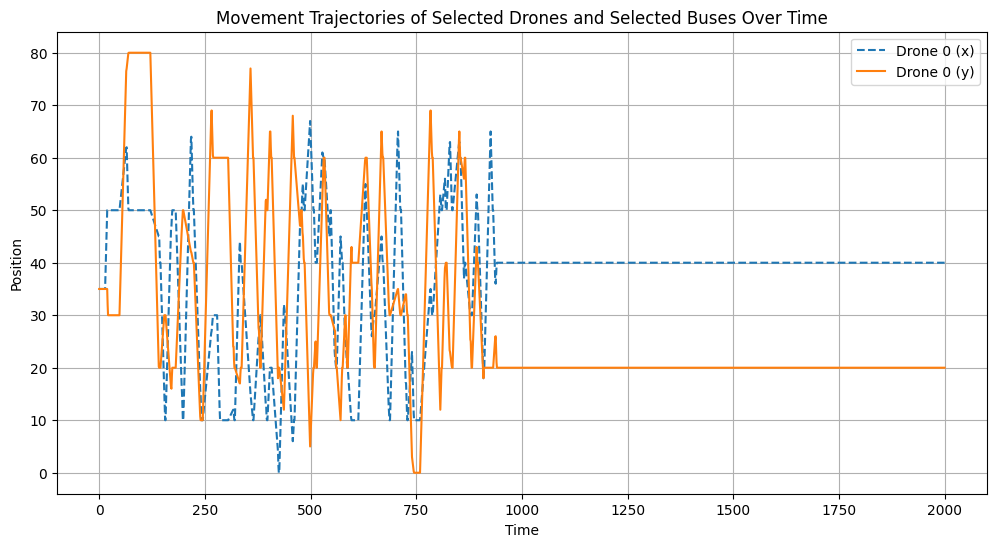

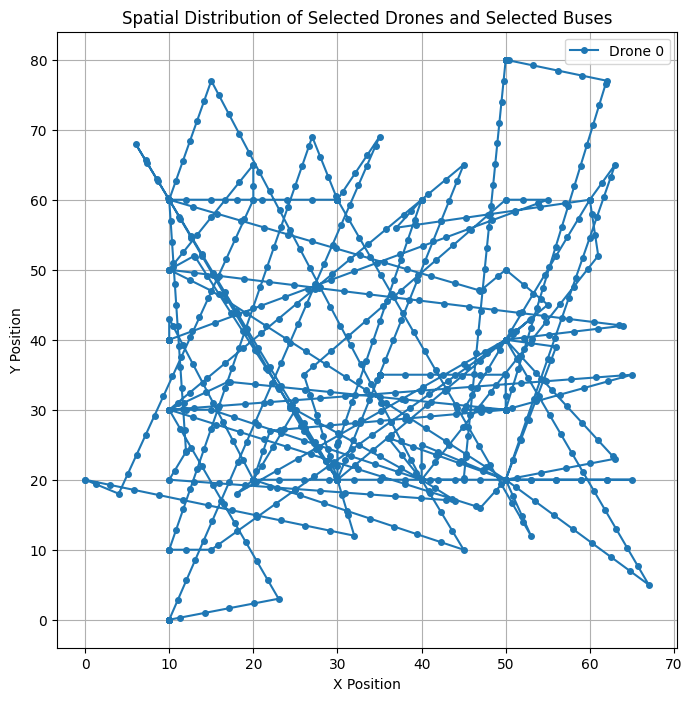

In [384]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 simulation_df 已经包含了所有记录
# 从列表中创建 DataFrame (如果还未创建)
simulation_df = pd.DataFrame(simulation_records)

# 将数据分成无人机和巴士
drones_df = simulation_df[simulation_df['entity'] == 'drone']
buses_df = simulation_df[simulation_df['entity'] == 'bus']

# Function to plot selected drones and selected buses
def plot_selected_drones_and_buses(drones_to_plot, buses_to_plot):
    # 1. 绘制无人机和巴士的运动轨迹随时间的变化
    plt.figure(figsize=(12, 6))
    for drone_id in drones_to_plot:
        drone_data = drones_df[drones_df['id'] == drone_id]
        if not drone_data.empty:
            plt.plot(drone_data['time'], drone_data['x'], label=f'Drone {drone_id} (x)', linestyle='--')
            plt.plot(drone_data['time'], drone_data['y'], label=f'Drone {drone_id} (y)')
    
    for bus_id in buses_to_plot:
        bus_data = buses_df[buses_df['id'] == bus_id]
        if not bus_data.empty:
            plt.plot(bus_data['time'], bus_data['x'], label=f'Bus {bus_id} (x)')
            plt.plot(bus_data['time'], bus_data['y'], label=f'Bus {bus_id} (y)', linestyle='--')

    plt.title("Movement Trajectories of Selected Drones and Selected Buses Over Time")
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.legend()
    plt.grid()
    plt.show()

    # 2. 绘制无人机和巴士的空间位置分布
    plt.figure(figsize=(8, 8))
    for drone_id in drones_to_plot:
        drone_data = drones_df[drones_df['id'] == drone_id]
        if not drone_data.empty:
            plt.plot(drone_data['x'], drone_data['y'], label=f'Drone {drone_id}', marker='o', markersize=4, linestyle='-')
    
    for bus_id in buses_to_plot:
        bus_data = buses_df[buses_df['id'] == bus_id]
        if not bus_data.empty:
            plt.plot(bus_data['x'], bus_data['y'], label=f'Bus {bus_id}', marker='x', markersize=5, linestyle='--')

    plt.title("Spatial Distribution of Selected Drones and Selected Buses")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage: Plot trajectories for drones with IDs [1, 3, 8] and buses with IDs [0, 2]
selected_drones = [0]
selected_buses = []
plot_selected_drones_and_buses(selected_drones, selected_buses)

In [285]:
tasks

[{'index': 0,
  'pickup_task': 12.0,
  'pickup_time': 15.0,
  'delivery_task': 95.0,
  'pickup_x': 50.0,
  'pickup_y': 35.0,
  'delivery_x': 25.0,
  'delivery_y': 24.0,
  'distance': 27.313000567495326,
  'pickup_status': 'completed',
  'delivery_status': 'unassigned'},
 {'index': 1,
  'pickup_task': 2.0,
  'pickup_time': 18.0,
  'delivery_task': 85.0,
  'pickup_x': 35.0,
  'pickup_y': 17.0,
  'delivery_x': 16.0,
  'delivery_y': 22.0,
  'distance': 19.6468827043885,
  'pickup_status': 'completed',
  'delivery_status': 'unassigned'},
 {'index': 2,
  'pickup_task': 21.0,
  'pickup_time': 18.0,
  'delivery_task': 18.0,
  'pickup_x': 45.0,
  'pickup_y': 20.0,
  'delivery_x': 20.0,
  'delivery_y': 40.0,
  'distance': 32.01562118716424,
  'pickup_status': 'completed',
  'delivery_status': 'unassigned'},
 {'index': 3,
  'pickup_task': 5.0,
  'pickup_time': 20.0,
  'delivery_task': 93.0,
  'pickup_x': 15.0,
  'pickup_y': 30.0,
  'delivery_x': 18.0,
  'delivery_y': 24.0,
  'distance': 6.7082039

In [286]:
hhh

NameError: name 'hhh' is not defined

In [ ]:
# import pandas as pd
# import numpy as np
# from scipy.spatial.distance import cdist

# # 巴士站类，记录位置
# class BusStation:
#     def __init__(self, x, y):
#         self.x = x
#         self.y = y

# # 无人机类，负责区域内的取货和将物品送至巴士站
# class Drone:
#     def __init__(self, drone_id, region, x, y):
#         self.drone_id = drone_id
#         self.region = region  # 无人机负责的区域编号
#         self.x = x
#         self.y = y
#         self.status = 'idle'  # 初始状态为空闲
#         self.current_task = None
#         self.target_x = None
#         self.target_y = None
#         self.time_until_idle = 0  # 剩余时间
#         self.tasks_completed = 0  # 统计无人机完成的任务数

#     def assign_task(self, task, nearest_bus_station):
#         self.current_task = task
#         self.status = 'moving_to_pickup'
#         self.target_x = task['pickup_x']
#         self.target_y = task['pickup_y']
#         self.time_until_idle = abs(self.target_x - self.x) + abs(self.target_y - self.y)

#     def move(self):
#         if self.status == 'idle' or self.time_until_idle <= 0:
#             return

#         # 无人机移动
#         if self.x != self.target_x:
#             self.x += np.sign(self.target_x - self.x)
#         elif self.y != self.target_y:
#             self.y += np.sign(self.target_y - self.y)

#         self.time_until_idle -= 1

#         # 如果无人机到达目标
#         if self.x == self.target_x and self.y == self.target_y:
#             if self.status == 'moving_to_pickup':
#                 # 无人机将物品带到巴士站
#                 self.status = 'moving_to_bus_station'
#                 nearest_bus_station = find_nearest_bus_station(self.current_task['pickup_x'], self.current_task['pickup_y'], bus_stations)
#                 self.target_x, self.target_y = nearest_bus_station.x, nearest_bus_station.y
#                 self.time_until_idle = abs(self.target_x - self.x) + abs(self.target_y - self.y)
#             elif self.status == 'moving_to_bus_station':
#                 # 完成任务，记录完成次数
#                 self.tasks_completed += 1
#                 self.status = 'idle'
#                 self.current_task = None

# # 巴士系统负责跨区域运输
# class BusSystem:
#     def __init__(self, travel_time=30):
#         self.travel_time = travel_time  # 运输时间
#         self.tasks_transported = 0  # 统计巴士运输的次数

#     def transport(self, task, bus_stations):
#         pickup_x, pickup_y = task['pickup_x'], task['pickup_y']
#         delivery_x, delivery_y = task['delivery_x'], task['delivery_y']
#         nearest_pickup_station = find_nearest_bus_station(pickup_x, pickup_y, bus_stations)
#         nearest_delivery_station = find_nearest_bus_station(delivery_x, delivery_y, bus_stations)
        
#         # 记录运输任务
#         self.tasks_transported += 1
#         return nearest_delivery_station

# # 查找离给定位置最近的巴士站
# def find_nearest_bus_station(x, y, bus_stations):
#     distances = cdist([(x, y)], [(bs.x, bs.y) for bs in bus_stations])
#     nearest_index = np.argmin(distances)
#     return bus_stations[nearest_index]

# # 读取巴士站的x和y坐标并初始化巴士站
# bus_stations = [BusStation(row['x'], row['y']) for index, row in bus_stations_df.iterrows()]

# # 初始化无人机，6台无人机从(35, 35)开始，分配不同的区域
# drones = [Drone(i, i // 2, 35, 35) for i in range(6)]  # 每两个无人机负责一个区域


# # 初始化巴士系统
# bus_system = BusSystem()

# # 创建一个 DataFrame 来存储每个时间点的信息
# columns = ['time'] + [f'drone_{i}_x' for i in range(len(drones))] + [f'drone_{i}_y' for i in range(len(drones))] + [f'drone_{i}_status' for i in range(len(drones))]
# data = []

# # 模拟运行
# current_time = 0
# time_step = 1
# total_time = 2000

# # 任务处理循环
# for index, task in pairs_df.iterrows():
#     pickup_time = task['pickup_earliest_time']
    
#     # 等待到取货时间
#     while current_time < pickup_time:
#         # 所有无人机移动
#         for drone in drones:
#             drone.move()

#         # 记录当前时间所有无人机的信息
#         current_info = [current_time] + [drone.x for drone in drones] + [drone.y for drone in drones] + [drone.status for drone in drones]
#         data.append(current_info)

#         current_time += time_step

#     # 查找空闲无人机
#     available_drone = next((d for d in drones if d.status == 'idle' and d.region == (index % len(drones))), None)
#     if available_drone:
#         available_drone.assign_task(task, 

In [ ]:
find_nearest_bus_station(task['pickup_x'], task['pickup_y'], bus_stations)

#     # 巴士系统转运物品
#     delivery_station = bus_system.transport(task, bus_stations)

#     # 在目标区域内分配无人机完成最终配送
#     for drone in drones:
#         if drone.region == index % len(drones) and drone.status == 'idle':
#             drone.assign_task(task, delivery_station)

# # 将数据存入 DataFrame
# df_simulation = pd.DataFrame(data, columns=columns)

# # 显示前几行数
# df_simulation

SyntaxError: unmatched ')' (227220960.py, line 1)

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # 假设 df_simulation 是你提供的 DataFrame，包含每个时刻的无人机状态和位置

# # 1. 绘制无人机在 x 和 y 坐标上的移动路径
# plt.figure(figsize=(10, 6))

# # 绘制每个无人机的 x 和 y 变化情况
# for i in range(6):  # 6 台无人机
#     plt.plot(df_simulation['time'], df_simulation[f'drone_{i}_x'], label=f'Drone {i} X', linestyle='--')
#     plt.plot(df_simulation['time'], df_simulation[f'drone_{i}_y'], label=f'Drone {i} Y')

# plt.title('Drone Movement Over Time (X and Y coordinates)')
# plt.xlabel('Time')
# plt.ylabel('Position (X, Y)')
# plt.legend()
# plt.grid(True)
# plt.show()

# # 2. 统计每个无人机不同状态的时长（比如 idle、moving_to_pickup 等）
# status_counts = pd.DataFrame()

# for i in range(6):  # 遍历所有无人机
#     status_count = df_simulation[f'drone_{i}_status'].value_counts()
#     status_counts[f'Drone {i}'] = status_count

# # 绘制无人机状态统计图
# status_counts.plot(kind='bar', figsize=(10, 6))
# plt.title('Drone Status Distribution')
# plt.xlabel('Status')
# plt.ylabel('Count')
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.show()

# # 3. 每个无人机的移动距离计算
# # 计算每个无人机在每个时间点的移动距离，简单的用相邻时刻位置的差值表示
# for i in range(6):
#     df_simulation[f'drone_{i}_distance'] = ((df_simulation[f'drone_{i}_x'].diff() ** 2) + (df_simulation[f'drone_{i}_y'].diff() ** 2)) ** 0.5

# # 绘制每个无人机的累计移动距离
# plt.figure(figsize=(10, 6))
# for i in range(6):
#     plt.plot(df_simulation['time'], df_simulation[f'drone_{i}_distance'].cumsum(), label=f'Drone {i} Distance')

# plt.title('Cumulative Distance Traveled by Each Drone')
# plt.xlabel('Time')
# plt.ylabel('Cumulative Distance')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# from gurobipy import Model, GRB, quicksum
# import math
# import pandas as pd
# import matplotlib.pyplot as plt

# # 假设 pairs_df 已经创建，并包含 'pickup_x', 'pickup_y', 'delivery_x', 'delivery_y' 列

# # 定义所有任务点（包括 depot）
# tasks = list(pairs_df['pickup_task']) + list(pairs_df['delivery_task'])
# tasks = [0] + tasks  # 包括depot，假设depot的任务编号为0

# # 计算所有点之间的距离
# def calculate_distance(x1, y1, x2, y2):
#     return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# # 创建距离矩阵
# distances = {}
# for i in tasks:
#     for j in tasks:
#         if i != j:
#             if i == 0:  # depot
#                 x_i, y_i = 40, 50  # 假设depot坐标为(40, 50)
#             else:
#                 if i in pairs_df['pickup_task'].values:
#                     x_i = pairs_df.loc[pairs_df['pickup_task'] == i, 'pickup_x'].values[0]
#                     y_i = pairs_df.loc[pairs_df['pickup_task'] == i, 'pickup_y'].values[0]
#                 elif i in pairs_df['delivery_task'].values:
#                     x_i = pairs_df.loc[pairs_df['delivery_task'] == i, 'delivery_x'].values[0]
#                     y_i = pairs_df.loc[pairs_df['delivery_task'] == i, 'delivery_y'].values[0]
                
#             if j == 0:  # depot
#                 x_j, y_j = 40, 50  # 假设depot坐标为(40, 50)
#             else:
#                 if j in pairs_df['pickup_task'].values:
#                     x_j = pairs_df.loc[pairs_df['pickup_task'] == j, 'pickup_x'].values[0]
#                     y_j = pairs_df.loc[pairs_df['pickup_task'] == j, 'pickup_y'].values[0]
#                 elif j in pairs_df['delivery_task'].values:
#                     x_j = pairs_df.loc[pairs_df['delivery_task'] == j, 'delivery_x'].values[0]
#                     y_j = pairs_df.loc[pairs_df['delivery_task'] == j, 'delivery_y'].values[0]

#             distances[(i, j)] = calculate_distance(x_i, y_i, x_j, y_j)

# # 创建Gurobi模型
# model = Model('VRP')

# # 决策变量: 是否从任务i到任务j
# x = model.addVars(distances.keys(), vtype=GRB.BINARY, name='x')

# # 辅助变量: 用于消除子循环
# u = model.addVars(tasks, vtype=GRB.CONTINUOUS, name='u')

# # 目标函数: 最小化总距离
# model.setObjective(quicksum(x[i, j] * distances[i, j] for i, j in distances.keys()), GRB.MINIMIZE)

# # 每个点只能访问一次
# model.addConstrs(quicksum(x[i, j] for j in tasks if j != i) == 1 for i in tasks)
# model.addConstrs(quicksum(x[j, i] for j in tasks if j != i) == 1 for i in tasks)

# # 消除子循环的约束（MTZ约束）
# model.addConstrs(u[i] - u[j] + len(tasks) * x[i, j] <= len(tasks) - 1 for i in tasks for j in tasks if i != j and i != 0 and j != 0)

# # 解决模型
# model.optimize()

# # 输出结果并绘制路径
# if model.status == GRB.OPTIMAL:
#     solution = model.getAttr('x', x)
    
#     plt.figure(figsize=(10, 8))
    
#     # 绘制所有任务点
#     for i in tasks:
#         if i == 0:  # Depot
#             plt.scatter(40, 50, color='black', label='Depot')
#         else:
#             if i in pairs_df['pickup_task'].values:
#                 x_coord = pairs_df.loc[pairs_df['pickup_task'] == i, 'pickup_x'].values[0]
#                 y_coord = pairs_df.loc[pairs_df['pickup_task'] == i, 'pickup_y'].values[0]
#                 plt.scatter(x_coord, y_coord, color='green', label='Pickup' if i == 1 else "")
#             elif i in pairs_df['delivery_task'].values:
#                 x_coord = pairs_df.loc[pairs_df['delivery_task'] == i, 'delivery_x'].values[0]
#                 y_coord = pairs_df.loc[pairs_df['delivery_task'] == i, 'delivery_y'].values[0]
#                 plt.scatter(x_coord, y_coord, color='orange', label='Delivery' if i == 1 else "")
    
#     # 绘制路径
#     for i, j in solution:
#         if solution[i, j] > 0.5:
#             if i == 0:
#                 x_i, y_i = 40, 50  # Depot
#             else:
#                 if i in pairs_df['pickup_task'].values:
#                     x_i = pairs_df.loc[pairs_df['pickup_task'] == i, 'pickup_x'].values[0]
#                     y_i = pairs_df.loc[pairs_df['pickup_task'] == i, 'pickup_y'].values[0]
#                 elif i in pairs_df['delivery_task'].values:
#                     x_i = pairs_df.loc[pairs_df['delivery_task'] == i, 'delivery_x'].values[0]
#                     y_i = pairs_df.loc[pairs_df['delivery_task'] == i, 'delivery_y'].values[0]

#             if j == 0:
#                 x_j, y_j = 40, 50  # Depot
#             else:
#                 if j in pairs_df['pickup_task'].values:
#                     x_j = pairs_df.loc[pairs_df['pickup_task'] == j, 'pickup_x'].values[0]
#                     y_j = pairs_df.loc[pairs_df['pickup_task'] == j, 'pickup_y'].values[0]
#                 elif j in pairs_df['delivery_task'].values:
#                     x_j = pairs_df.loc[pairs_df['delivery_task'] == j, 'delivery_x'].values[0]
#                     y_j = pairs_df.loc[pairs_df['delivery_task'] == j, 'delivery_y'].values[0]

#             # 绘制从任务i到任务j的路径线段
#             plt.plot([x_i, x_j], [y_i, y_j], color='black')

#     # 添加图例
#     plt.legend(handles=[
#         plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Depot'),
#         plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Pickup'),
#         plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Delivery')
#     ])

#     plt.title('Optimized Task Route')
#     plt.xlabel('X Coordinate')
#     plt.ylabel('Y Coordinate')
#     plt.grid(True)
    
#     # 显示图表
#     plt.show()

# else:
#     print("No optimal solution found.")

## Time windows

## Budget

In [ ]:

def optimize_tour(n, Start_id, points, reward, cost, B, distance, early, late, Dining, Sightseeing, Recreational):
    m = gp.Model()

    # Decision variables
    x = m.addVars(n, vtype=GRB.BINARY, name="x")  # Activity selection
    y = tupledict({(i, j): m.addVar(vtype=GRB.BINARY, name=f'y[{i},{j}]') for i in range(n) for j in range(n)})  # Transitions
    t = m.addVars(n, vtype=GRB.CONTINUOUS, lb=0, name="t")  # Time of arrival at each activity

    # Objective function
    m.setObjective(
        quicksum(reward[i] * x[i] for i in range(n)) -
        quicksum(cost[i] * x[i] for i in range(1, n)) -
        quicksum(distance[i, j] * y[i, j] for i in range(n) for j in range(n) if i != j),
        GRB.MAXIMIZE
    )

    # Constraints
    m.addConstrs((y[i, i] == 0 for i in range(n)), name="no_self_loop")
    for i in range(n):
        inflow = quicksum(y[j, i] for j in range(n))
        outflow = quicksum(y[i, j] for j in range(n))
        m.addConstr(inflow == outflow, name=f"flow_conserv_{i}")
        m.addConstr(x[i] == inflow, name=f"activity_{i}_inflow")
        m.addConstr(x[i] == outflow, name=f"activity_{i}_outflow")

    m.addConstr(
        quicksum(cost[i] * x[i] for i in range(1, n)) +
        quicksum(distance[i, j] * y[i, j] for i in range(n) for j in range(n) if i != j) <= B,
        "Budget"
    )

    for i in range(1, n):
        m.addGenConstrIndicator(x[i], True, t[i] >= early[i], name=f"time_window_start_{i}")
        m.addGenConstrIndicator(x[i], True, t[i] <= late[i], name=f"time_window_end_{i}")

    for i in range(n):
        for j in range(n):
            if i != j:
                m.addGenConstrIndicator(y[i, j], True, t[j] >= (0 if i == Start_id else t[i] + distance[i, j]), name=f"transit_time_{i}_{j}")

    # Specific activity sequence constraints
    for i in range(1, n):
        if i in Recreational or i in Sightseeing:
            m.addConstr(quicksum(y[i, j] for j in Dining) >= x[i], name=f"Dining_follows_{i}")

    # Group selection constraints
    m.addConstr(quicksum(x[i] for i in Recreational) == 1, "One_per_Recreational")
    m.addConstr(quicksum(x[i] for i in Sightseeing) == 1, "One_per_Sightseeing")
    m.addConstr(quicksum(x[i] for i in Dining) == 2, "Two_Dining")

    # Start and end at the hotel
    m.addConstr(quicksum(y[Start_id, j] for j in range(n)) == 1, "Start_from_hotel")
    m.addConstr(quicksum(y[i, Start_id] for i in range(n)) == 1, "End_at_hotel")

    # Solving the model
    m.optimize()

    # Extracting the path if the solution is optimal
    path = [Start_id]
    if m.status == GRB.OPTIMAL:
        # Determine the starting point
        current = Start_id
        visited = set()
        for _ in range(n):
            # Select the next activity based on the transition variable y
            next_activities = [j for j in range(n) if y[current, j].X > 0.5 and j not in visited]
            if not next_activities:
                break
            next_activity = next_activities[0]
            path.append(next_activity)
            visited.add(next_activity)
            current = next_activity

    return path, m.objVal if m.status == GRB.OPTIMAL else None
# Call the function and capture the result
tour, net_reward = optimize_tour(n, Start_id, points, reward, cost, B, distance, early, late, Dining, Sightseeing, Recreational)
print(tour)

NameError: name 'n' is not defined

In [ ]:
budget = B
cost[0]=0
cost_dict = cost

In [ ]:
def heuristic_itinerary(points, distance, start_id, cost, budget, early, late, Dining, Recreational, Sightseeing, reward, n):
    current_position = start_id
    path = [start_id]  # Start at the hotel
    total_cost = 0
    total_reward = reward[start_id]  # Initialize reward with the start point's reward
    visited = {start_id}  # Keep track of visited points
    activities_done = {'Dining': 0, 'Recreational': 0, 'Sightseeing': 0}

    def select_activity(activities, required_type=None):
        best_activity = None
        best_value = float('-inf')
        for activity in activities:
            if activity in visited or (current_position, activity) not in distance:
                continue
            projected_cost = total_cost + cost.get(activity, 0) + distance[(current_position, activity)]
            if projected_cost > budget or not (total_cost + distance[(current_position, activity)] <= late.get(activity, float('inf'))):
                continue
            if required_type and activity_type(activity) != required_type:
                continue  # Skip if activity type does not match the required type
            value = reward[activity] - projected_cost
            if value > best_value:
                best_activity = activity
                best_value = value
        return best_activity

    def add_activity(activity):
        nonlocal total_cost, current_position, total_reward
        if activity:
            path.append(activity)
            visited.add(activity)
            activity_cost = cost.get(activity, 0) + distance[(current_position, activity)]
            total_cost += activity_cost
            total_reward += reward[activity]
            current_position = activity
            activities_done[activity_type(activity)] += 1
            print(f"Added {activity_type(activity)} {activity}: Cost={activity_cost}, Total Cost={total_cost}")

    def activity_type(activity):
        if activity in Dining:
            return 'Dining'
        elif activity in Recreational:
            return 'Recreational'
        elif activity in Sightseeing:
            return 'Sightseeing'
        return None

    # First main activity (either Recreational or Sightseeing)
    first_main_activity = select_activity(Recreational + Sightseeing)
    if first_main_activity:
        add_activity(first_main_activity)

    # First dining activity
    first_dining = select_activity(Dining, required_type='Dining')
    if first_dining:
        add_activity(first_dining)
    else:
        print("No suitable first dining activity found within constraints.")

    # Second main activity (other type than first)
    other_type = 'Recreational' if activity_type(first_main_activity) == 'Sightseeing' else 'Sightseeing'
    second_main_activity = select_activity([x for x in (Recreational + Sightseeing) if x != first_main_activity], required_type=other_type)
    if second_main_activity:
        add_activity(second_main_activity)

    # Second dining activity
    second_dining = select_activity(Dining, required_type='Dining')
    if second_dining:
        add_activity(second_dining)
    else:
        print("No suitable second dining activity found within constraints.")

    # Return to the hotel
    if current_position != start_id:
        path.append(start_id)
        return_to_hotel_cost = distance[(current_position, start_id)]
        total_cost += return_to_hotel_cost
        print(f"Returning to start: Cost={return_to_hotel_cost}, Total Cost={total_cost}")

    net_reward = total_reward - total_cost
    return path, net_reward

# Example call to the function with placeholders for actual data
path, net_reward = heuristic_itinerary(points, distance, Start_id, cost, budget, early, late, Dining, Recreational, Sightseeing, reward, n)
print("Path:", path)
print("Net Utility:", net_reward)


Added Recreational 41: Cost=16.0, Total Cost=16.0
Added Dining 6: Cost=21.1049731745428, Total Cost=37.1049731745428
Added Sightseeing 40: Cost=19.0, Total Cost=56.1049731745428
Added Dining 18: Cost=12.0, Total Cost=68.1049731745428
Returning to start: Cost=38.07886552931954, Total Cost=106.18383870386235
Path: [0, 41, 6, 40, 18, 0]
Net Utility: 35.437892132289804


In [ ]:
def figure(t, points, Dining, Sightseeing, Recreational, Start_id, name):
    # plt.figure(figsize=(8, 5))
    ax = plt.gca()

    ax.set_xlim((-5, 105))
    ax.set_ylim((-5, 105))

    for idx, point in enumerate(points):
        if idx in Dining:
            ax.plot(point[1], point[0], 'ro', label='Dining' if idx == Dining[0] else "")
        elif idx in Sightseeing:
            ax.plot(point[1], point[0], 'yo', label='Sightseeing' if idx == Sightseeing[0] else "")
        elif idx in Recreational:
            ax.plot(point[1], point[0], 'go', label='Recreational' if idx == Recreational[0] else "")

    ax.plot(points[Start_id][1], points[Start_id][0], 's', color='black', label='Start')

    x_path = [points[i][1] for i in t] + [points[t[0]][1]]
    y_path = [points[i][0] for i in t] + [points[t[0]][0]]
    ax.plot(x_path, y_path, 'k--', label='Path')

    plt.legend()
    plt.savefig(name)
    plt.show()
    

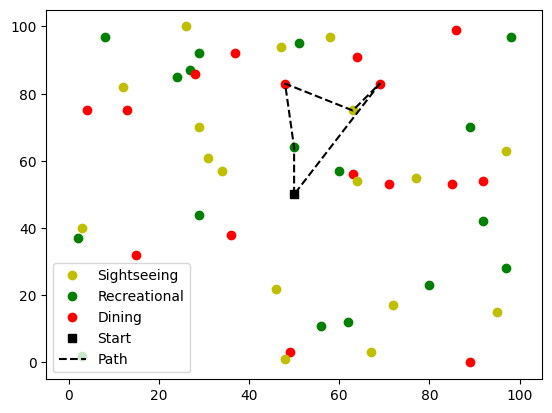

In [ ]:
figure(tour, points, Dining, Sightseeing, Recreational, Start_id,'foo.png')

Added Recreational 17: Cost=69.17886572427373, Total Cost=69.17886572427373
Added Dining 3: Cost=34.31098884280702, Total Cost=103.48985456708076
Added Sightseeing 19: Cost=47.27692569068709, Total Cost=150.76678025776783
Added Dining 39: Cost=40.897300677553446, Total Cost=191.6640809353213
Returning to start: Cost=18.439088914585774, Total Cost=210.10316984990706
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 21.6.0 21H1123)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 244 rows, 2703 columns and 13785 nonzeros
Model fingerprint: 0xb5c9ade4
Model has 2650 general constraints
Variable types: 51 continuous, 2652 integer (2652 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
  GenCon rhs range [1e+00, 7e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 654 rows and 

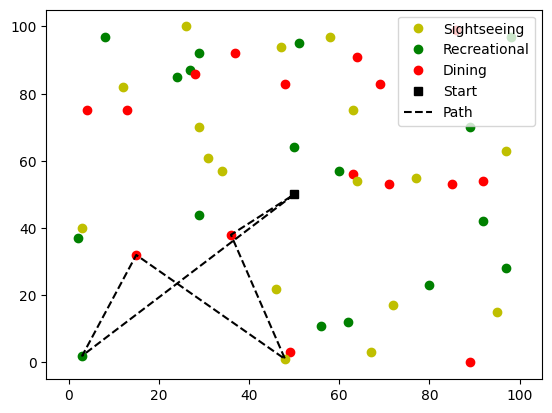

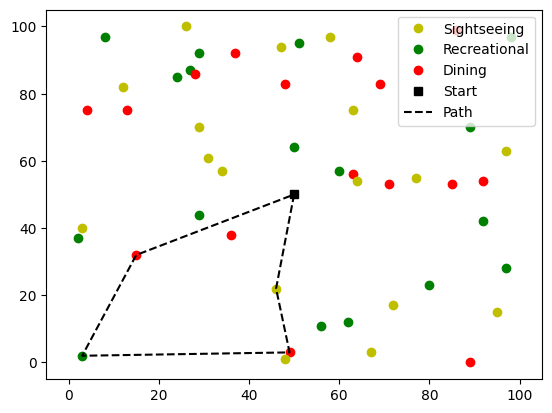

In [ ]:
# Big Reward Scenario
big_reward = {k: v * 2 for k, v in reward.items()}
path_h_big_reward, net_reward_h_big_reward = heuristic_itinerary(points, distance, Start_id, cost, B, early, late, Dining, Recreational, Sightseeing, big_reward, n)
path_o_big_reward, net_reward_o_big_reward = optimize_tour(n, Start_id, points, big_reward, cost, B, distance, early, late, Dining, Sightseeing, Recreational)

print("---Big Reward Scenario---")
print("Heuristic Itinerary Path:", path_h_big_reward)
print("Heuristic Itinerary Net Reward:", net_reward_h_big_reward)
print("Optimize Tour Path:", path_o_big_reward)
print("Optimize Tour Net Reward:", net_reward_o_big_reward)
figure(path_h_big_reward, points, Dining, Sightseeing, Recreational, Start_id, 'Big_Reward_Heuristic.png')
figure(path_o_big_reward, points, Dining, Sightseeing, Recreational, Start_id, 'Big_Reward_Optimize.png')




Added Sightseeing 46: Cost=30.284271247461902, Total Cost=30.284271247461902
Added Dining 39: Cost=20.867962264113206, Total Cost=51.152233511575105
Added Recreational 17: Cost=50.83646178829912, Total Cost=101.98869529987422
Added Dining 3: Cost=34.31098884280702, Total Cost=136.29968414268126
Returning to start: Cost=39.35733730830886, Total Cost=175.6570214509901
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 21.6.0 21H1123)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 244 rows, 2703 columns and 13785 nonzeros
Model fingerprint: 0xdcf450f2
Model has 2650 general constraints
Variable types: 51 continuous, 2652 integer (2652 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
  GenCon rhs range [1e+00, 7e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 654 rows and

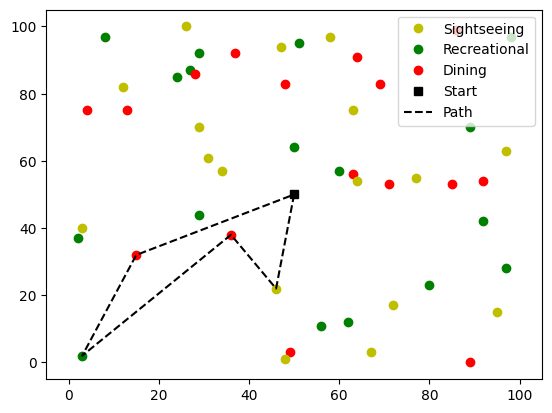

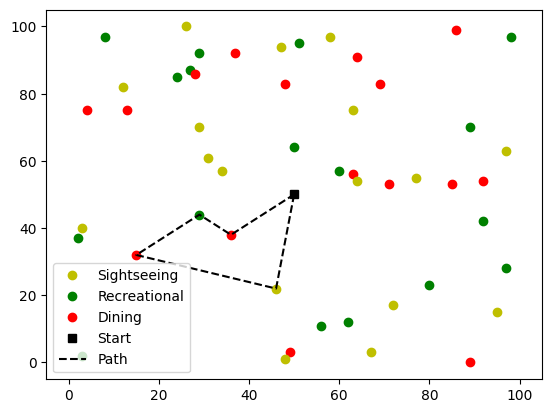

In [ ]:
# Several Big Rewards Scenario
several_big_reward = reward.copy()
keys_to_increase = list(reward.keys())[:5]
for key in keys_to_increase:
    several_big_reward[key] *= 6

path_h_several_big_rewards, net_reward_h_several_big_rewards = heuristic_itinerary(points, distance, Start_id, cost, B, early, late, Dining, Recreational, Sightseeing, several_big_reward, n)
path_o_several_big_rewards, net_reward_o_several_big_rewards = optimize_tour(n, Start_id, points, several_big_reward, cost, B, distance, early, late, Dining, Sightseeing, Recreational)

print("---Several Big Rewards Scenario---")
print("Heuristic Itinerary Path:", path_h_several_big_rewards)
print("Heuristic Itinerary Net Reward:", net_reward_h_several_big_rewards)
print("Optimize Tour Path:", path_o_several_big_rewards)
print("Optimize Tour Net Reward:", net_reward_o_several_big_rewards)

figure(path_h_several_big_rewards, points, Dining, Sightseeing, Recreational, Start_id, 'Several_Big_Rewards_Heuristic.png')
figure(path_o_several_big_rewards, points, Dining, Sightseeing, Recreational, Start_id, 'Several_Big_Rewards_Optimize.png')



In [ ]:
keys_to_increase

[46, 50, 8, 1, 32]

Added Recreational 41: Cost=16.0, Total Cost=16.0
Added Dining 6: Cost=21.1049731745428, Total Cost=37.1049731745428
Added Sightseeing 40: Cost=19.0, Total Cost=56.1049731745428
Added Dining 18: Cost=12.0, Total Cost=68.1049731745428
Returning to start: Cost=38.07886552931954, Total Cost=106.18383870386235
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 21.6.0 21H1123)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 244 rows, 2703 columns and 13785 nonzeros
Model fingerprint: 0x8ef62cfe
Model has 2650 general constraints
Variable types: 51 continuous, 2652 integer (2652 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
  GenCon rhs range [1e+00, 7e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 75 rows and 0 columns
Presolve removed 0 rows and 2194 columns
Presolve t

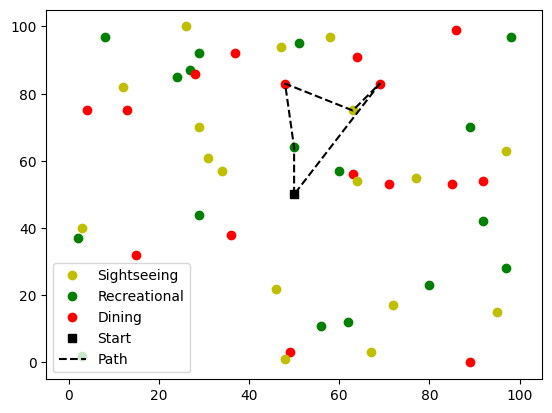

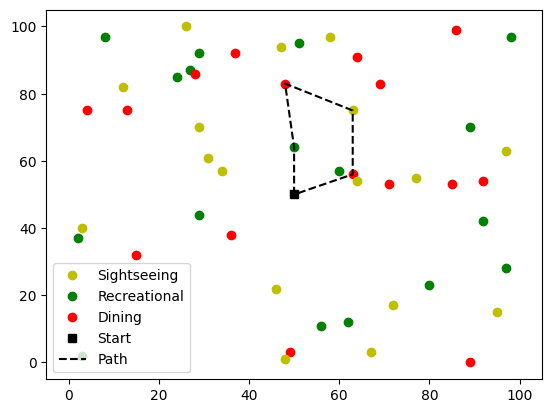

In [ ]:
# Limited Budget Scenario
limited_budget = B / 3

path_h_limited_budget, net_reward_h_limited_budget = heuristic_itinerary(points, distance, Start_id, cost, limited_budget, early, late, Dining, Recreational, Sightseeing, reward, n)
path_o_limited_budget, net_reward_o_limited_budget = optimize_tour(n, Start_id, points, reward, cost, limited_budget, distance, early, late, Dining, Sightseeing, Recreational)

print("---Limited Budget Scenario---")
print("Heuristic Itinerary Path:", path_h_limited_budget)
print("Heuristic Itinerary Net Reward:", net_reward_h_limited_budget)
print("Optimize Tour Path:", path_o_limited_budget)
print("Optimize Tour Net Reward:", net_reward_o_limited_budget)

figure(path_h_limited_budget, points, Dining, Sightseeing, Recreational, Start_id, 'Limited_Budget_Heuristic.png')
figure(path_o_limited_budget, points, Dining, Sightseeing, Recreational, Start_id, 'Limited_Budget_Optimize.png')




In [ ]:

# class Label:
#     parent = None
#     customer= None
#     cost = 0.0
#     time = 0.0
#     distance = 0
#     utility = 0
#     def __init__(self, l=None, node=0):
#         self.customer = node
#         if l:
#             self.cost = l.cost + distance[(l.customer, node)] + cost_dict[node]
#             self.time = resource_extension_T(l, node)
#             self.utility = l.utility + reward[node] - distance[(l.customer, node)] - cost_dict[node]
#             self.distance = l.distance + distance[(l.customer, node)]
            
#             activity_type = get_activity_type(node)
#             if activity_type:  # Ensure activity_type is not None before accessing the dictionary
#                 self.activities_count = dict(l.activities_count)
#                 self.activities_count[activity_type] = self.activities_count.get(activity_type, 0) + 1
#                 self.last_activity = activity_type
#             else:
#                 self.activities_count = dict(l.activities_count)
#                 self.last_activity = None
            
#         else:
#             self.activities_count = {'Dining': 0, 'Recreational': 0, 'Sightseeing': 0, 'Other': 0}
#             self.last_activity = None
#         self.parent = l



# def resource_extension_T(label, next_node):
#     # Assuming you have a function to calculate new time based on previous label and travel time to next_node
#     return label.time + distance[(label.customer, next_node)]  # Simple additive time increment

# def get_activity_type(node):
#     if node in Dining:
#         return 'Dining'
#     elif node in Recreational:
#         return 'Recreational'
#     elif node in Sightseeing:
#         return 'Sightseeing'
#     else:
#         return 'Other'

# def dominance(l1, l2):
#     """Returns true if l1 dominates l2"""
#     return l1.utility >= l2.utility 

# def feasible(l, i):
#     """Returns if extending from label l to node i is feasible."""
#     # Check if it's feasible to go to node i from label l
#     if l.customer == i:
#         return False
#     # ex 2.1: Time constraints
#     if distance[(l.customer, i)] + l.time > late[i]:
#         return False
#     # ex 2.2: Time constraints
#     if distance[(l.customer, i)] + l.time < early[i]:
#         return False
#     # Check if Dining happens after every activity
#     activity_type = get_activity_type(i)
#         # 确保回家前完成必要的活动数量
#     if i == Start_id:  # 假设 Start_id 是家的节点
#         if l.activities_count['Dining'] < 2 or l.activities_count['Recreational'] < 1 or l.activities_count['Sightseeing'] < 1:
#             return False
#     if activity_type == 'Dining':
#         if l.last_activity is not None and l.last_activity != 'Dining':
#             return False
#     # Check that only one activity per group of activities can be done
#     # 特定活动的次数限制
#     if activity_type == 'Dining':
#         if l.activities_count[activity_type] >= 2:  # Dining 可以进行最多两次
#             return False
#     elif activity_type in ['Recreational', 'Sightseeing']:
#         if l.activities_count[activity_type] >= 1:  # Recreational 和 Sightseeing 只能进行一次
#             return False

#     return True

# # Now let's redefine the labeling algorithm with included feasibility check
# import random

# def labeling_algorithm():
#     l0 = Label()
#     M = {(k, i): [] for k in range(n) for i in range(n)}
#     M[(0, Start_id)].append(l0)  # Initial label at the start node

#     for k in range(1, n):  # Number of nodes visited
#         for i in range(n):  # Current node
#             random_j_nodes = list(range(1, n))
#             random.shuffle(random_j_nodes)  # Randomize the order of nodes
#             for j in random_j_nodes:  # New node to extend to
#                 if j == i:
#                     continue
#                 for l in random.sample(M[(k-1, i)], len(M[(k-1, i)])):  # Randomize labels order
#                     if feasible(l, j):
#                         l2 = Label(l, j)
#                         dominated = False
#                         M_kj = M[(k, j)]
#                         random.shuffle(M_kj)  # Randomize the order of existing labels in M[k, j]
#                         for l1 in M_kj:
#                             if dominance(l1, l2):
#                                 dominated = True
#                                 break
#                             elif dominance(l2, l1):
#                                 M[(k, j)].remove(l1)
#                         if not dominated and (random.random() < 1 or len(M[(k, j)]) == 0):  # 95% chance to accept
#                             M[(k, j)].append(l2)

#     return best_label(M)


# def best_label(M):
#     best_l = None
#     highest_utility = float('-inf')

#     for k in range(1, n):
#         for i in range(1, n):
#             for l in M[(k, i)]:
#                 # 这里初始时 best_l 是 None，所以我们需要检查它是否被赋值
#                 if best_l is None:
#                     # 第一次赋值，没有东西可以比较，直接设置为当前标签
#                     best_l = l
#                     highest_utility = l.utility - distance[(l.customer, Start_id)]
#                 else:
#                     a = distance[(l.customer, Start_id)]
#                     b = distance[(best_l.customer, Start_id)]
#                     current_utility = l.utility - a
#                     if current_utility > highest_utility:
#                         best_l = l
#                         highest_utility = current_utility

#     if best_l is not None:
#         print("Best label found with utility: ", highest_utility)
#     else:
#         print("No valid label found.")

#     return best_l
